In [337]:
# Алгоритм считает 100 возможных стратегий за 21.3 сек
# 1000 комбинаций - за 120 секунд
# 25344 - 45 минут 

In [339]:
# !pip install yahoo_fin
# !pip install yoptions
# !pip install pandas_datareader
# pip install lightgbm
# !pip install --upgrade xlrd

In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.2f}'.format

import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import figure
import seaborn as sns
import os
import datetime
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import time

start = time.time()

In [100]:
CFTC_futures_only = pd.read_csv('C:/Users/LT17/Desktop/Другое/Учёба/Все файлы от 30.12.22/CFTC_futures_only.csv')
all_commodities = pd.read_csv('C:/Users/LT17/Desktop/Другое/Учёба/Все файлы от 30.12.22/all_commodities_modified.csv') 

all_commodities.drop_duplicates(subset = all_commodities.columns, inplace = True)
CFTC_futures_only.drop_duplicates(subset = CFTC_futures_only.columns, inplace = True)

CFTC_futures_only.Report_Date_as_MM_DD_YYYY = pd.to_datetime(CFTC_futures_only.Report_Date_as_MM_DD_YYYY)
all_commodities.Date = pd.to_datetime(all_commodities.Date)
CFTC_futures_only.sort_values(by = 'Report_Date_as_MM_DD_YYYY', ascending = False, inplace = True)

# Выравниваем датафреймы CFTC и с Коммодитис
all_commodities = all_commodities.loc[all_commodities.Date >= CFTC_futures_only.Report_Date_as_MM_DD_YYYY.min()]

# (!!!) Начиная с февраля 2022 года ряд фьючерсов по natural газ изменили наименования _____________________________
# CFTC_futures_only[CFTC_futures_only.Market_and_Exchange_Names.str.contains('GAS')].Market_and_Exchange_Names.unique()

CFTC_futures_only.Market_and_Exchange_Names = np.where(CFTC_futures_only.Market_and_Exchange_Names.str \
                                                       .contains('NAT GAS NYME - NEW YORK MERCANTILE EXCHANGE'),
                                                       str('NATURAL GAS - NEW YORK MERCANTILE EXCHANGE'),
                                                       CFTC_futures_only.Market_and_Exchange_Names)

# NATURAL GAS - NEW YORK MERCANTILE EXCHANGE был переименован в NAT GAS NYME - NEW YORK MERCANTILE EXCHANGE
# NAT GAS NYME - NEW YORK MERCANTILE EXCHANGE будем использовать для дальнейшего анализа

In [ ]:
for i in CFTC_futures_only[CFTC_futures_only.Market_and_Exchange_Names.str.contains('GAS')].Market_and_Exchange_Names.unique():
    if CFTC_futures_only[CFTC_futures_only.Market_and_Exchange_Names.str.contains(i)].Report_Date_as_MM_DD_YYYY.max() > pd.to_datetime("2022-12-01"):
        print(i, '//', CFTC_futures_only[CFTC_futures_only.Market_and_Exchange_Names.str.contains(i)].Report_Date_as_MM_DD_YYYY.max())

### Ищем необходимые фьючерсы. Работать будем только с Gold_Futures, Brent_Oil_Futures, Natural_Gas_Futures

In [101]:
# Ищем все уникальные типы фьючерсов, содержащих слова Oil, Gold
print(all_commodities[all_commodities.ticker.str.contains('Oil')].ticker.unique(), '\n')
print(all_commodities[all_commodities.ticker.str.contains('Gold')].ticker.unique(), '\n')
print(all_commodities[all_commodities.ticker.str.contains('Gas')].ticker.unique())

['Brent_Oil_Futures' 'Crude_Oil_WTI_Futures' 'Heating_Oil_Futures'
 'London_Gas_Oil_Futures' 'US_Soybean_Oil_Futures'] 

['Gold_Futures'] 

['Gasoline_RBOB_Futures' 'London_Gas_Oil_Futures' 'Natural_Gas_Futures']


### Предобработка датафрейма с базовыми активами (Crude_oil, Gold)

In [102]:
all_commodities = all_commodities.applymap(lambda x: str(x).replace(',', ''))
all_commodities.drop(columns = ['Unnamed: 0'], inplace = True)
all_commodities.Date = pd.to_datetime(all_commodities.Date)
#
all_commodities.Price = all_commodities.Price.astype('float')
all_commodities.Open = all_commodities.Open.astype('float')
all_commodities.High = all_commodities.High.astype('float')
all_commodities.Low = all_commodities.Low.astype('float')
#
all_commodities.rename(columns = {'Vol.': 'Volume',
                               'Change %': 'growth_rate'}, inplace = True)
all_commodities.Volume.replace('nan', 0, inplace = True)
all_commodities.growth_rate = all_commodities.growth_rate.apply(lambda x: str(x).replace('%', ''))
all_commodities.ticker = all_commodities.ticker.apply(lambda x: str(x).replace('HistoricalData', '')) ####
#
all_commodities.Date = pd.to_datetime(all_commodities.Date) ####
all_commodities['year'] = all_commodities.Date.dt.year

In [103]:
def value_to_float(x):
    if type(x) == float or type(x) == int:
        return x
    
    if 'K' in x:
        if len(x) > 1:
            return float(x.replace('K', '')) * 10
        return 1000.0
    
    if 'M' in x:
        if len(x) > 1:
            return float(x.replace('M', '')) * 10000
        return 1000000.0
    
    if 'B' in x:
        return float(x.replace('B', '')) * 10000000
    return 0.0

all_commodities.growth_rate = all_commodities.growth_rate.apply(lambda x: float(x))
all_commodities.Volume = all_commodities.Volume.apply(value_to_float)

### Отсекаем данные по дате, чтобы все датафреймы были одинаковой длины

In [105]:
# FUTURES
Oil = all_commodities.query('ticker == "Brent_Oil_Futures" & year >= 2006')
Gas = all_commodities.query('ticker == "Natural_Gas_Futures" & year >= 2006')
gold = all_commodities.query('ticker == "Gold_Futures" & year >= 2006')

# STOCKS
shell = pd.read_csv('C:/Users/LT17/Desktop/Другое/Учёба/Все файлы от 30.12.22/Фондовый рынок/SHELL_oil.csv') 
exxon = pd.read_csv('C:/Users/LT17/Desktop/Другое/Учёба/Все файлы от 30.12.22/Фондовый рынок/exxon_oil.csv')
barrickgold = pd.read_csv('C:/Users/LT17/Desktop/Другое/Учёба/Все файлы от 30.12.22/Фондовый рынок/barrickgold.csv')
newportgold = pd.read_csv('C:/Users/LT17/Desktop/Другое/Учёба/Все файлы от 30.12.22/Фондовый рынок/newport_gold.csv')

BP = pd.read_csv('C:/Users/LT17/Desktop/Другое/Учёба/Все файлы от 30.12.22/Фондовый рынок/BP.csv')
petrochina = pd.read_csv('C:/Users/LT17/Desktop/Другое/Учёба/Все файлы от 30.12.22/Фондовый рынок/chinapetroleum.csv')

shell.rename(columns = {'Vol.': 'Volume',
                               'Изм. %': 'growth_rate'}, inplace = True)
exxon.columns = list(shell.columns)
barrickgold.columns = list(shell.columns)
newportgold.columns = list(shell.columns)
BP.columns = list(shell.columns)
petrochina.columns = list(shell.columns)

barrickgold.Date = pd.to_datetime(barrickgold.Date).dt.strftime('%Y-%m-%d')
newportgold.Date = pd.to_datetime(newportgold.Date).dt.strftime('%Y-%m-%d')
BP.Date = pd.to_datetime(BP.Date).dt.strftime('%Y-%m-%d')
petrochina.Date = pd.to_datetime(petrochina.Date).dt.strftime('%Y-%m-%d')

shell[['Date', 'Price', 'Open', 'High', 'Low', 'Change %']] = shell[['Date',
                                                                     'Price',
                                                                     'Open',
                                                                     'High',
                                                                     'Low',
                                                                     'Change %']] \
                                                              .applymap(lambda x: str(x).replace(',', '.'))

exxon[['Date', 'Price', 'Open', 'High', 'Low', 'Change %']] = exxon[['Date',
                                                                     'Price',
                                                                     'Open',
                                                                     'High',
                                                                     'Low',
                                                                     'Change %']] \
                                                              .applymap(lambda x: str(x).replace(',', '.'))

barrickgold[['Date', 'Price', 'Open', 'High', 'Low', 'Change %']] = barrickgold[['Date',
                                                                                 'Price',
                                                                                 'Open',
                                                                                 'High',
                                                                                 'Low',
                                                                                 'Change %']] \
                                                              .applymap(lambda x: str(x).replace(',', '.'))

newportgold[['Date', 'Price', 'Open', 'High', 'Low', 'Change %']] = newportgold[['Date',
                                                                                 'Price',
                                                                                 'Open',
                                                                                 'High',
                                                                                 'Low',
                                                                                 'Change %']] \
                                                              .applymap(lambda x: str(x).replace(',', '.'))

BP[['Date', 'Price', 'Open', 'High', 'Low', 'Change %']] = BP[['Date',
                                                                     'Price',
                                                                     'Open',
                                                                     'High',
                                                                     'Low',
                                                                     'Change %']] \
                                                              .applymap(lambda x: str(x).replace(',', '.'))

petrochina[['Date', 'Price', 'Open', 'High', 'Low', 'Change %']] = petrochina[['Date',
                                                                               'Price',
                                                                               'Open',
                                                                               'High',
                                                                               'Low',
                                                                               'Change %']] \
                                                              .applymap(lambda x: str(x).replace(',', '.'))


shell.Volume = shell.Volume.apply(lambda x: str(x).replace(',', ''))
exxon.Volume = exxon.Volume.apply(lambda x: str(x).replace(',', ''))
barrickgold.Volume = barrickgold.Volume.apply(lambda x: str(x).replace(',', ''))
newportgold.Volume = newportgold.Volume.apply(lambda x: str(x).replace(',', ''))
BP.Volume = BP.Volume.apply(lambda x: str(x).replace(',', ''))
petrochina.Volume = petrochina.Volume.apply(lambda x: str(x).replace(',', ''))

newportgold.Volume = newportgold.Volume.apply(value_to_float).astype('int')
barrickgold.Volume = barrickgold.Volume.apply(value_to_float).astype('int')
BP.Volume = BP.Volume.apply(value_to_float).astype('int')
petrochina.Volume = petrochina.Volume.apply(value_to_float).astype('int')

newportgold.Date = pd.to_datetime(newportgold.Date, dayfirst=False)
barrickgold.Date = pd.to_datetime(barrickgold.Date, dayfirst=False)
exxon.Date = pd.to_datetime(exxon.Date, dayfirst=False)
shell.Date = pd.to_datetime(shell.Date, dayfirst=False)
BP.Date = pd.to_datetime(BP.Date, dayfirst=False)
petrochina.Date = pd.to_datetime(petrochina.Date, dayfirst=False)

exxon = exxon.loc[(exxon.Date >= CFTC_futures_only.Report_Date_as_MM_DD_YYYY.min()) & (exxon.Date <= Oil.Date.max())]
shell = shell.loc[(shell.Date >= CFTC_futures_only.Report_Date_as_MM_DD_YYYY.min()) & (shell.Date <= Oil.Date.max())]
BP = BP.loc[(BP.Date >= CFTC_futures_only.Report_Date_as_MM_DD_YYYY.min()) & (BP.Date <= Oil.Date.max())]
petrochina = petrochina.loc[(petrochina.Date >= CFTC_futures_only.Report_Date_as_MM_DD_YYYY.min()) & (petrochina.Date <= Oil.Date.max())]

shell = shell.loc[shell.Date.isin(list(exxon.Date))]
exxon = exxon.loc[exxon.Date.isin(list(shell.Date))]

BP = BP.loc[BP.Date.isin(list(exxon.Date))]
petrochina = petrochina.loc[petrochina.Date.isin(list(shell.Date))]

shell = shell.query('Date >= "2010-01-05"')
exxon = exxon.query('Date >= "2010-01-05"')
Oil = Oil.loc[Oil.Date.isin(list(shell.Date))]
Gas = Gas.loc[Gas.Date.isin(list(shell.Date))]

newportgold = newportgold.loc[(newportgold.Date >= CFTC_futures_only.Report_Date_as_MM_DD_YYYY.min()) & (newportgold.Date <= gold.Date.max())]
barrickgold = barrickgold.loc[(barrickgold.Date >= CFTC_futures_only.Report_Date_as_MM_DD_YYYY.min()) & (barrickgold.Date <= gold.Date.max())]
gold = gold.loc[gold.Date.isin(list(barrickgold.Date))]

exxon.Price = exxon.Price.apply(lambda x: float(x))
shell.Price = shell.Price.apply(lambda x: float(x))
barrickgold.Price = barrickgold.Price.apply(lambda x: float(x))
newportgold.Price = newportgold.Price.apply(lambda x: float(x))

print('Newport gold: Размер выборки: ', newportgold.shape)
print('Barrick gold: Размер выборки: ', barrickgold.shape,'\n')
print('Exxon: Размер выборки: ', exxon.shape)
print('BP: Размер выборки: ', BP.shape)
print('Petrochina: Размер выборки: ', petrochina.shape)
print('Shell: Размер выборки: ', shell.shape, '\n')
print('Gas: Размер выборки: ', Gas.shape)
print('Oil: Размер выборки: ', Oil.shape,'\n')

Newport gold: Размер выборки:  (2903, 7)
Barrick gold: Размер выборки:  (2903, 7) 

Exxon: Размер выборки:  (2855, 7)
BP: Размер выборки:  (2855, 7)
Petrochina: Размер выборки:  (2855, 7)
Shell: Размер выборки:  (2855, 7) 

Gas: Размер выборки:  (2855, 9)
Oil: Размер выборки:  (2855, 9) 



## Форматируем датафреймы с динамикой базового актива фьючерсов, с динамикой фьючерсов из отчета CFTC, с акциями "зеркальных" активов

In [106]:
# АКЦИИ__________________________________________________________________________________________________________

# SHELL (OIL / GAS)
shell[['High', 'Low']] = shell[['High', 'Low']].applymap(lambda x: float(x))
shell['intraday_diff'] = shell.High - shell.Low
shell.Volume = shell.Volume.apply(value_to_float)
shell.sort_values(by = 'Date', ascending = True, inplace = True)
shell['2weeks_savg'] = shell['Price'].rolling(14).mean()
shell = shell[['Date', 'Price', 'Volume', 'intraday_diff', '2weeks_savg']]
shell.dropna(inplace = True)

# Petrochina (OIL/ GAS)
petrochina[['High', 'Low']] = petrochina[['High', 'Low']].applymap(lambda x: float(x))
petrochina['intraday_diff'] = petrochina.High - petrochina.Low
petrochina.Volume = petrochina.Volume.apply(value_to_float)
petrochina.sort_values(by = 'Date', ascending = True, inplace = True)
petrochina['2weeks_savg'] = petrochina['Price'].rolling(14).mean()
petrochina = petrochina[['Date', 'Price', 'Volume', 'intraday_diff', '2weeks_savg']]
petrochina.dropna(inplace = True)

# BP (OIL/ GAS)
exxon[['High', 'Low']] = exxon[['High', 'Low']].applymap(lambda x: float(x))
exxon['intraday_diff'] = exxon.High - exxon.Low
exxon.Volume = exxon.Volume.apply(value_to_float)
exxon.sort_values(by = 'Date', ascending = True, inplace = True)
exxon['2weeks_savg'] = exxon['Price'].rolling(14).mean()
exxon = exxon[['Date', 'Price', 'Volume', 'intraday_diff', '2weeks_savg']]
exxon.dropna(inplace = True)

# ExxonMobil (OIL/ GAS)
BP[['High', 'Low']] = BP[['High', 'Low']].applymap(lambda x: float(x))
BP['intraday_diff'] = BP.High - BP.Low
BP.Volume = BP.Volume.apply(value_to_float)
BP.sort_values(by = 'Date', ascending = True, inplace = True)
BP['2weeks_savg'] = BP['Price'].rolling(14).mean()
BP = BP[['Date', 'Price', 'Volume', 'intraday_diff', '2weeks_savg']]
BP.dropna(inplace = True)

# newportgold (GOLD)
newportgold[['High', 'Low']] = newportgold[['High', 'Low']].applymap(lambda x: float(x))
newportgold['intraday_diff'] = newportgold.High - newportgold.Low
newportgold.Volume = newportgold.Volume.apply(value_to_float)
newportgold.sort_values(by = 'Date', ascending = True, inplace = True)
newportgold['2weeks_savg'] = newportgold['Price'].rolling(14).mean()
newportgold = newportgold[['Date', 'Price', 'Volume', 'intraday_diff', '2weeks_savg']]
newportgold.dropna(inplace = True)

# barrickgold (GOLD)
barrickgold[['High', 'Low']] = barrickgold[['High', 'Low']].applymap(lambda x: float(x))
barrickgold['intraday_diff'] = barrickgold.High - barrickgold.Low
barrickgold.Volume = barrickgold.Volume.apply(value_to_float)
barrickgold.sort_values(by = 'Date', ascending = True, inplace = True)
barrickgold['2weeks_savg'] = barrickgold['Price'].rolling(14).mean()
barrickgold = barrickgold[['Date', 'Price', 'Volume', 'intraday_diff', '2weeks_savg']]
barrickgold.dropna(inplace = True)

# ФЬЮЧЕРСЫ ______________________________________________________________________________________________________

Oil['intraday_diff'] = Oil.High - Oil.Low
Oil.rename(columns = {'ticker': 'Futures_Oil'}, inplace = True)

Oil = Oil[['Date',
           'Price',
           'intraday_diff',
           'growth_rate',
           'Volume',
           'Futures_Oil']]

gold['intraday_diff'] = gold.High - gold.Low
gold.rename(columns = {'ticker': 'Futures_gold'}, inplace = True)

gold = gold[['Date',
           'Price',
           'intraday_diff',
           'growth_rate',
           'Volume',
           'Futures_gold']]

# CFTC data _____________________________________________________________________________________________________

cftc_gold = CFTC_futures_only.query('Market_and_Exchange_Names == "GOLD - COMMODITY EXCHANGE INC."')

cftc_gold = cftc_gold[
                  ['Report_Date_as_MM_DD_YYYY',
                   'Open_Interest_All',
                   'Tot_Rept_Positions_Long_All',
                   'Tot_Rept_Positions_Short_All']
                   ]

cftc_gold['difference'] = cftc_gold.Tot_Rept_Positions_Long_All - cftc_gold.Tot_Rept_Positions_Short_All
cftc_gold.sort_values(by = 'Report_Date_as_MM_DD_YYYY', ascending = True, inplace = True )
cftc_gold['rolling_52_min'] = cftc_gold.difference.rolling(52).min()
cftc_gold['rolling_52_max'] = cftc_gold.difference.rolling(52).max()
cftc_gold['Williams_coef'] = round((cftc_gold.difference - cftc_gold['rolling_52_min']) / (cftc_gold['rolling_52_max'] - cftc_gold['rolling_52_min'])*100,2)
cftc_gold.dropna(inplace = True)

n_steps = 7
def my_fun(x):
    return x.iloc[-1] - x.iloc[0]

# # Раcчет индикатора Стивена Бриза (Movement Index) (Индекс Ульямса за текущую неделю за вычетом Индекса Ульямса N недель назад)
# # Если Movement Index > 40%, это означает завершение коррекции долгосрочного тренда; 
# # Если Movement Index < -40%, это означает завершение долгосрочного тренда;
cftc_gold['Breeze_coef'] = cftc_gold['Williams_coef'].rolling(window=n_steps).apply(my_fun)

cftc_gold = cftc_gold[['Report_Date_as_MM_DD_YYYY',
                       'Open_Interest_All',
                       'Tot_Rept_Positions_Long_All', 
                       'Tot_Rept_Positions_Short_All',
                       'difference',
                       'rolling_52_min',
                       'rolling_52_max',
                       'Williams_coef',
                       'Breeze_coef']]
# _______________________________________________________________________________________________________________

cftc_oil = CFTC_futures_only.query('Market_and_Exchange_Names == "BRENT CRUDE OIL LAST DAY - NEW YORK MERCANTILE EXCHANGE"')

cftc_oil = cftc_oil[
                  ['Report_Date_as_MM_DD_YYYY',
                   'Open_Interest_All',
                   'Tot_Rept_Positions_Long_All',
                   'Tot_Rept_Positions_Short_All']
                   ]

cftc_oil['difference'] = cftc_oil.Tot_Rept_Positions_Long_All - cftc_oil.Tot_Rept_Positions_Short_All
cftc_oil.sort_values(by = 'Report_Date_as_MM_DD_YYYY', ascending = True, inplace = True )
cftc_oil['rolling_52_min'] = cftc_oil.difference.rolling(52).min()
cftc_oil['rolling_52_max'] = cftc_oil.difference.rolling(52).max()
cftc_oil['Williams_coef'] = round((cftc_oil.difference - cftc_oil['rolling_52_min']) / (cftc_oil['rolling_52_max'] - cftc_oil['rolling_52_min'])*100,2)
cftc_oil['Breeze_coef'] = cftc_oil['Williams_coef'].rolling(window=n_steps).apply(my_fun)
cftc_oil.dropna(inplace = True)

cftc_oil = cftc_oil[['Report_Date_as_MM_DD_YYYY',
                       'Open_Interest_All',
                       'Tot_Rept_Positions_Long_All', 
                       'Tot_Rept_Positions_Short_All',
                       'difference',
                       'rolling_52_min',
                       'rolling_52_max',
                       'Williams_coef',
                       'Breeze_coef']]
# _______________________________________________________________________________________________________________

cftc_gas = CFTC_futures_only.query('Market_and_Exchange_Names == "NATURAL GAS - NEW YORK MERCANTILE EXCHANGE"')

cftc_gas = cftc_gas[
                  ['Report_Date_as_MM_DD_YYYY',
                   'Open_Interest_All',
                   'Tot_Rept_Positions_Long_All',
                   'Tot_Rept_Positions_Short_All']
                   ]

cftc_gas['difference'] = cftc_gas.Tot_Rept_Positions_Long_All - cftc_gas.Tot_Rept_Positions_Short_All
cftc_gas.sort_values(by = 'Report_Date_as_MM_DD_YYYY', ascending = True, inplace = True )
cftc_gas['rolling_52_min'] = cftc_gas.difference.rolling(52).min()
cftc_gas['rolling_52_max'] = cftc_gas.difference.rolling(52).max()
cftc_gas['Williams_coef'] = round((cftc_gas.difference - cftc_gas['rolling_52_min']) / (cftc_gas['rolling_52_max'] - cftc_gas['rolling_52_min'])*100,2)
cftc_gas['Breeze_coef'] = cftc_gas['Williams_coef'].rolling(window=n_steps).apply(my_fun)
cftc_gas.dropna(inplace = True)

cftc_gas = cftc_gas[['Report_Date_as_MM_DD_YYYY',
                       'Open_Interest_All',
                       'Tot_Rept_Positions_Long_All', 
                       'Tot_Rept_Positions_Short_All',
                       'difference',
                       'rolling_52_min',
                       'rolling_52_max',
                       'Williams_coef',
                       'Breeze_coef']]

## Итоговые датафреймы

In [107]:
print('Exxon min: ', exxon.Date.min())
print('BP min: ', BP.Date.min())
print('shell min: ', shell.Date.min())
print('petrochina min: ', petrochina.Date.min())

print('Exxon max: ', exxon.Date.max())
print('BP max: ', BP.Date.max())
print('shell max: ', shell.Date.max())
print('petrochina max: ', petrochina.Date.max())

Exxon min:  2010-01-25 00:00:00
BP min:  2010-01-25 00:00:00
shell min:  2010-01-25 00:00:00
petrochina min:  2010-01-25 00:00:00
Exxon max:  2021-06-15 00:00:00
BP max:  2021-06-15 00:00:00
shell max:  2021-06-15 00:00:00
petrochina max:  2021-06-15 00:00:00


In [349]:
# cftc_gas
exxon_gas = exxon.loc[exxon.Date >= cftc_gas.Report_Date_as_MM_DD_YYYY.min()]
bp_gas = BP.loc[BP.Date >= cftc_gas.Report_Date_as_MM_DD_YYYY.min()]
shell_gas = shell.loc[shell.Date >= cftc_gas.Report_Date_as_MM_DD_YYYY.min()]
petrochina_gas = petrochina.loc[petrochina.Date >= cftc_gas.Report_Date_as_MM_DD_YYYY.min()]

# cftc_oil
exxon_oil = exxon.loc[exxon.Date >= cftc_oil.Report_Date_as_MM_DD_YYYY.min()]
bp_oil = BP.loc[BP.Date >= cftc_oil.Report_Date_as_MM_DD_YYYY.min()]
shell_oil = shell.loc[shell.Date >= cftc_oil.Report_Date_as_MM_DD_YYYY.min()]
petrochina_oil = petrochina.loc[petrochina.Date >= cftc_oil.Report_Date_as_MM_DD_YYYY.min()]

# cftc_gold
newportgold = newportgold.loc[newportgold.Date >= cftc_gold.Report_Date_as_MM_DD_YYYY.min()]
barrickgold = barrickgold.loc[barrickgold.Date >= cftc_gold.Report_Date_as_MM_DD_YYYY.min()]

### Работаем сначала с ГАЗОМ

In [352]:
exxon_gas2 = pd.merge(exxon_gas, cftc_gas[['Williams_coef',
                                          'Breeze_coef',
                                          'Report_Date_as_MM_DD_YYYY',
                                          'Open_Interest_All']],
                                           how = 'left',
                                           left_on = 'Date',
                                           right_on = 'Report_Date_as_MM_DD_YYYY')

exxon_gas2.fillna(method="ffill", inplace = True)
exxon_gas2.drop(columns = 'Report_Date_as_MM_DD_YYYY', inplace = True)


bp_gas2 = pd.merge(bp_gas, cftc_gas[['Williams_coef',
                                    'Breeze_coef',
                                    'Report_Date_as_MM_DD_YYYY',
                                    'Open_Interest_All']],
                                     how = 'left',
                                     left_on = 'Date',
                                     right_on = 'Report_Date_as_MM_DD_YYYY')
bp_gas2.fillna(method="ffill", inplace = True)
bp_gas2.drop(columns = 'Report_Date_as_MM_DD_YYYY', inplace = True)

shell_gas2 = pd.merge(shell_gas, cftc_gas[['Williams_coef',
                                          'Breeze_coef',
                                          'Report_Date_as_MM_DD_YYYY',
                                          'Open_Interest_All']],
                                           how = 'left',
                                           left_on = 'Date',
                                           right_on = 'Report_Date_as_MM_DD_YYYY')
shell_gas2.fillna(method="ffill", inplace = True)
shell_gas2.drop(columns = 'Report_Date_as_MM_DD_YYYY', inplace = True)


petrochina_gas2 = pd.merge(petrochina_gas, cftc_gas[['Williams_coef',
                                                    'Breeze_coef',
                                                    'Report_Date_as_MM_DD_YYYY',
                                                    'Open_Interest_All']],
                                                     how = 'left',
                                                     left_on = 'Date',
                                                     right_on = 'Report_Date_as_MM_DD_YYYY')

petrochina_gas2.fillna(method="ffill", inplace = True)
petrochina_gas2.drop(columns = 'Report_Date_as_MM_DD_YYYY', inplace = True)

exxon_gas2 = pd.merge(exxon_gas2, Gas[['Price',
                                     'Date',
                                     'Volume']],
                                      how = 'left',
                                      on = 'Date')
exxon_gas2.rename(columns = {'Price_x': 'stock_price',
                            'Volume_x': 'stock_volume',
                            'Price_y': 'future_price',
                            'Volume_y': 'future_volume',
                            'Open_Interest_All': 'CFTC_OI_ALL'}, inplace = True)


bp_gas2 = pd.merge(bp_gas2, Gas[['Price',
                                     'Date',
                                     'Volume']],
                                      how = 'left',
                                      on = 'Date')
bp_gas2.rename(columns = {'Price_x': 'stock_price',
                            'Volume_x': 'stock_volume',
                            'Price_y': 'future_price',
                            'Volume_y': 'future_volume',
                            'Open_Interest_All': 'CFTC_OI_ALL'}, inplace = True)


shell_gas2 = pd.merge(shell_gas2, Gas[['Price',
                                     'Date',
                                     'Volume']],
                                      how = 'left',
                                      on = 'Date')
shell_gas2.rename(columns = {'Price_x': 'stock_price',
                            'Volume_x': 'stock_volume',
                            'Price_y': 'future_price',
                            'Volume_y': 'future_volume',
                            'Open_Interest_All': 'CFTC_OI_ALL'}, inplace = True)


petrochina_gas2 = pd.merge(petrochina_gas2, Gas[['Price',
                                     'Date',
                                     'Volume']],
                                      how = 'left',
                                      on = 'Date')
petrochina_gas2.rename(columns = {'Price_x': 'stock_price',
                            'Volume_x': 'stock_volume',
                            'Price_y': 'future_price',
                            'Volume_y': 'future_volume',
                            'Open_Interest_All': 'CFTC_OI_ALL'}, inplace = True)

petrochina_gas2.stock_price = petrochina_gas2.stock_price.astype('float')
shell_gas2.stock_price = shell_gas2.stock_price.astype('float')
bp_gas2.stock_price = bp_gas2.stock_price.astype('float')
exxon_gas2.stock_price = exxon_gas2.stock_price.astype('float')

# Рассчитываем к-т корр Спирмена за 1 год (оконная функция) между стоимостью акции и стоимостью фьючерса
petrochina_gas2['stock_to_future_corr'] = petrochina_gas2['stock_price'].rolling(365).corr(petrochina_gas2['future_price'])
shell_gas2['stock_to_future_corr'] = shell_gas2['stock_price'].rolling(365).corr(shell_gas2['future_price'])
bp_gas2['stock_to_future_corr'] = bp_gas2['stock_price'].rolling(365).corr(bp_gas2['future_price'])
exxon_gas2['stock_to_future_corr'] = exxon_gas2['stock_price'].rolling(365).corr(exxon_gas2['future_price'])

days_gas_total = (exxon.loc[exxon.Date >= cftc_gas.Report_Date_as_MM_DD_YYYY.min()].Date.max() - exxon.loc[exxon.Date >= cftc_gas.Report_Date_as_MM_DD_YYYY.min()].Date.min()).days

## Теперь разрабатываем механизм выявление того, через какой промежуток времени после превышения критических отметок индексов Уильямса и Бриза произойдет разворот рынка

### Лепим во все датафреймы столбец с триггером по индексу У., индексу Б + в финальном столбце индикатор того, что прокрасился и индекс У, и индекс Б.

In [353]:
max_Will_range = np.arange(71,99,3.5)
min_Will_range = np.arange(16,29,3.5)
max_Breeze_range = np.arange(32,63,3.5)
min_Breeze_range = np.arange(-24,-49, -3.5)
corr_corr_range = np.arange(0.59,0.95, 0.035)

import itertools

def iteration_loop():
    k = {
    0: max_Will_range,
    1: min_Will_range,
    2: max_Breeze_range,
    3: min_Breeze_range,
    4: corr_corr_range
    }
    
    return list(itertools.product(*k.values()))

s = list(iteration_loop())

IndentationError: unexpected indent (3299631275.py, line 10)

In [ ]:
# k = {
# 0: max_Will_range,
# 1: min_Will_range,
# 2: max_Breeze_range,
# 3: min_Breeze_range,
# 4: corr_corr_range}

In [ ]:
# DF_for_comparison = pd.DataFrame(columns = ['Сделок_всего',
#                                             'сделок_LONG',
#                                             'avg_profit_pershare_LONG_14',
#                                             'avg_profit_pershare_LONG_21',
#                                             'avg_profit_pershare_LONG_28',
#                                             'сделок_SHORT',
#                                             'profit_SHORT_14',
#                                             'profit_SHORT_21',
#                                             'profit_SHORT_28',
#                                             '365_days_features_stock_corr',
#                                             'max_Will',
#                                             'min_Will',
#                                             'max_Br',
#                                             'min_Br'])

# z = 0
# for i in s:

#     max_Will = i[0]
#     min_Will = i[1]
#     max_Breeze = i[2]
#     min_Breeze = i[3]
#     corr_corr = i[4]

#     dict_of_happiness = {'max_Will': max_Will, 
#     'min_Will': min_Will,
#     'max_Breeze': max_Breeze,
#     'min_Breeze': min_Breeze,
#     'corr_corr': corr_corr}

#     petrochina_gas = petrochina_gas2 # Перепривязывание переменных нужно, что функция put_call_function могла итерироваться бесконечное число раз
#     shell_gas = shell_gas2
#     bp_gas = bp_gas2
#     exxon_gas = exxon_gas2

#     def put_call_function(df):

#         df['long_short_Williams'] = np.where((df.Williams_coef >= max_Will) & (df.stock_to_future_corr >= corr_corr),
#                                         str('short'),
#                                         np.where((df.Williams_coef <= min_Will) & (df.stock_to_future_corr >= corr_corr), str('long'), "" ))

#         df['long_short_Breeze'] = np.where((df.Breeze_coef >= max_Breeze) & (df.stock_to_future_corr >= corr_corr),
#                                         str('short'),
#                                         np.where((df.Breeze_coef <= min_Breeze) & (df.stock_to_future_corr >= corr_corr), str('long'), "" ))

#         df['both'] = np.where(
#                              (df['long_short_Breeze'] == "long") 
#                               & (df['long_short_Williams'] == df['long_short_Breeze']), 
#                               "Both_long",
#                               np.where((df['long_short_Breeze'] == "short") 
#                               & (df['long_short_Williams'] == df['long_short_Breeze']),
#                               "Both_short",
#                               "Not_the_same")
#                              )
#         return df

#     ### Переворачиваем столбец stock_price кверх ногами и находим разницу по столбцам 
#     # stock_price & shift30 по тем строкам, где прокрасились индексы У, Б.

#     def get_values_2_4weeks(df):
#         df['shift14'] = df.stock_price.shift(-14)
#         df['shift21'] = df.stock_price.shift(-21)
#         df['shift28'] = df.stock_price.shift(-28)
#         df['profit14'] = df.stock_price - df['shift14']
#         df['profit21'] = df.stock_price - df['shift21']
#         df['profit28'] = df.stock_price - df['shift28']
#         df.drop(columns = ['shift14', 'shift21', 'shift28'], inplace = True)
#         return df
    
#     def dates_grouping(df):    
#         df['grp_date'] = df.Date.diff().dt.days.ne(1).cumsum()
#         return df

#     def long_short(df):
#         df = df.query('both == "Both_long" | both == "Both_short"') \
#                    .groupby(['long_short_Breeze', 'grp_date'], as_index = False) \
#                    .agg({'Date': 'first',
#                          'profit14': 'first',
#                          'profit21': 'first',
#                          'profit28': 'first',
#                          'stock_price': 'first'})
#         df['year'] = df.Date.dt.year
#         df['month'] = df.Date.dt.month
#         df['day'] = df.Date.dt.day
#         df.drop_duplicates(subset = ['long_short_Breeze', 'month'], keep = 'first', inplace = True)

#         for i in range(0, df.shape[0]):
#             if (df.iloc[i-1,-3] - df.iloc[i,-3] == 1) & (df.iloc[i-1,-2] - df.iloc[i,-2]) == -11 & (df.iloc[i-1,-1] - df.iloc[i,-1]) < -21:
#                 df.drop(df.index[i], inplace = True)
#             elif (df.iloc[i-1,-2] - df.iloc[i,-2] == -11) & (df.iloc[i-1,-1] - df.iloc[i,-1] < -22):
#                 df.drop(df.index[i], inplace = True)     
#         return df

#     gas_list = [exxon_gas,
#                 shell_gas,
#                 petrochina_gas,
#                 bp_gas]

#     for i in gas_list:

#         i = put_call_function(i)
#         i = get_values_2_4weeks(i)
#         i = dates_grouping(i)

#     bp_gas = long_short(bp_gas)
#     shell_gas = long_short(shell_gas)
#     exxon_gas = long_short(exxon_gas)
#     petrochina_gas = long_short(petrochina_gas)

#     gas_list = [exxon_gas,
#                 shell_gas,
#                 petrochina_gas,
#                 bp_gas]

#     df_gas = pd.DataFrame()
#     for i in range(len(gas_list)):
#         df_gas = pd.concat([df_gas,gas_list[i]], axis = 0, ignore_index=False)
        
#     perfect_row_of_happiness = [df_gas.shape[0],
#                         df_gas.query('long_short_Breeze == "long"').shape[0],
#                         round(list(df_gas.query('long_short_Breeze == "long"').iloc[:,3:6].mean().values)[0], 2),
#                         round(list(df_gas.query('long_short_Breeze == "long"').iloc[:,3:6].mean().values)[1], 2),
#                         round(list(df_gas.query('long_short_Breeze == "long"').iloc[:,3:6].mean().values)[2], 2),
#                         df_gas.query('long_short_Breeze == "short"').shape[0],
#                         round(list(df_gas.query('long_short_Breeze == "short"').iloc[:,3:6].mean().values)[0], 2),
#                         round(list(df_gas.query('long_short_Breeze == "short"').iloc[:,3:6].mean().values)[1], 2),
#                         round(list(df_gas.query('long_short_Breeze == "short"').iloc[:,3:6].mean().values)[2], 2),
#                         corr_corr,
#                         max_Will,
#                         min_Will,
#                         max_Breeze,
#                         min_Breeze]
    
#     DF_for_comparison = DF_for_comparison.append(pd.Series(perfect_row_of_happiness, index = DF_for_comparison.columns),
#                                                  ignore_index = True)
#     print(z / len(list(itertools.product(*k.values()))))

# end = time.time()
# print(end - start)
# DF_for_comparison.to_csv('D:/Учёба/ВКР/ИтоговыеДатафреймы/GAS.csv')
# DF_for_comparison

# Теперь НЕФТЬ

In [ ]:
exxon_oil2 = pd.merge(exxon_oil, cftc_oil[['Williams_coef',
                                          'Breeze_coef',
                                          'Report_Date_as_MM_DD_YYYY',
                                          'Open_Interest_All']],
                                           how = 'left',
                                           left_on = 'Date',
                                           right_on = 'Report_Date_as_MM_DD_YYYY')

exxon_oil2.fillna(method="ffill", inplace = True)
exxon_oil2.drop(columns = 'Report_Date_as_MM_DD_YYYY', inplace = True)


bp_oil2 = pd.merge(bp_oil, cftc_oil[['Williams_coef',
                                    'Breeze_coef',
                                    'Report_Date_as_MM_DD_YYYY',
                                    'Open_Interest_All']],
                                     how = 'left',
                                     left_on = 'Date',
                                     right_on = 'Report_Date_as_MM_DD_YYYY')
bp_oil2.fillna(method="ffill", inplace = True)
bp_oil2.drop(columns = 'Report_Date_as_MM_DD_YYYY', inplace = True)

shell_oil2 = pd.merge(shell_oil, cftc_oil[['Williams_coef',
                                          'Breeze_coef',
                                          'Report_Date_as_MM_DD_YYYY',
                                          'Open_Interest_All']],
                                           how = 'left',
                                           left_on = 'Date',
                                           right_on = 'Report_Date_as_MM_DD_YYYY')
shell_oil2.fillna(method="ffill", inplace = True)
shell_oil2.drop(columns = 'Report_Date_as_MM_DD_YYYY', inplace = True)


petrochina_oil2 = pd.merge(petrochina_oil, cftc_oil[['Williams_coef',
                                                    'Breeze_coef',
                                                    'Report_Date_as_MM_DD_YYYY',
                                                    'Open_Interest_All']],
                                                     how = 'left',
                                                     left_on = 'Date',
                                                     right_on = 'Report_Date_as_MM_DD_YYYY')

petrochina_oil2.fillna(method="ffill", inplace = True)
petrochina_oil2.drop(columns = 'Report_Date_as_MM_DD_YYYY', inplace = True)

exxon_oil2 = pd.merge(exxon_oil2, Oil[['Price',
                                     'Date',
                                     'Volume']],
                                      how = 'left',
                                      on = 'Date')
exxon_oil2.rename(columns = {'Price_x': 'stock_price',
                            'Volume_x': 'stock_volume',
                            'Price_y': 'future_price',
                            'Volume_y': 'future_volume',
                            'Open_Interest_All': 'CFTC_OI_ALL'}, inplace = True)


bp_oil2 = pd.merge(bp_oil2, Oil[['Price',
                                     'Date',
                                     'Volume']],
                                      how = 'left',
                                      on = 'Date')
bp_oil2.rename(columns = {'Price_x': 'stock_price',
                            'Volume_x': 'stock_volume',
                            'Price_y': 'future_price',
                            'Volume_y': 'future_volume',
                            'Open_Interest_All': 'CFTC_OI_ALL'}, inplace = True)


shell_oil2 = pd.merge(shell_oil2, Oil[['Price',
                                     'Date',
                                     'Volume']],
                                      how = 'left',
                                      on = 'Date')
shell_oil2.rename(columns = {'Price_x': 'stock_price',
                            'Volume_x': 'stock_volume',
                            'Price_y': 'future_price',
                            'Volume_y': 'future_volume',
                            'Open_Interest_All': 'CFTC_OI_ALL'}, inplace = True)


petrochina_oil2 = pd.merge(petrochina_oil2, Oil[['Price',
                                     'Date',
                                     'Volume']],
                                      how = 'left',
                                      on = 'Date')
petrochina_oil2.rename(columns = {'Price_x': 'stock_price',
                            'Volume_x': 'stock_volume',
                            'Price_y': 'future_price',
                            'Volume_y': 'future_volume',
                            'Open_Interest_All': 'CFTC_OI_ALL'}, inplace = True)

petrochina_oil2.stock_price = petrochina_oil2.stock_price.astype('float')
shell_oil2.stock_price = shell_oil2.stock_price.astype('float')
bp_oil2.stock_price = bp_oil2.stock_price.astype('float')
exxon_oil2.stock_price = exxon_oil2.stock_price.astype('float')

# Рассчитываем к-т корр Спирмена за 1 год (оконная функция) между стоимостью акции и стоимостью фьючерса
petrochina_oil2['stock_to_future_corr'] = petrochina_oil2['stock_price'].rolling(365).corr(petrochina_oil2['future_price'])
shell_oil2['stock_to_future_corr'] = shell_oil2['stock_price'].rolling(365).corr(shell_oil2['future_price'])
bp_oil2['stock_to_future_corr'] = bp_oil2['stock_price'].rolling(365).corr(bp_oil2['future_price'])
exxon_oil2['stock_to_future_corr'] = exxon_oil2['stock_price'].rolling(365).corr(exxon_oil2['future_price'])

days_oil_total = (exxon.loc[exxon.Date >= cftc_oil.Report_Date_as_MM_DD_YYYY.min()].Date.max() - exxon.loc[exxon.Date >= cftc_oil.Report_Date_as_MM_DD_YYYY.min()].Date.min()).days

# max_Will_range = np.arange(71,99,3.5)
# min_Will_range = np.arange(16,29,3.5)
# max_Breeze_range = np.arange(32,63,3.5)
# min_Breeze_range = np.arange(-22,-49, -3.5)
# corr_corr_range = np.arange(0.5,0.95, 0.04)

# DF_for_comparison_Oil = pd.DataFrame(columns = ['Сделок_всего',
#                                             'сделок_LONG',
#                                             'avg_profit_pershare_LONG_14',
#                                             'avg_profit_pershare_LONG_21',
#                                             'avg_profit_pershare_LONG_28',
#                                             'сделок_SHORT',
#                                             'profit_SHORT_14',
#                                             'profit_SHORT_21',
#                                             'profit_SHORT_28',
#                                             '365_days_features_stock_corr',
#                                             'max_Will',
#                                             'min_Will',
#                                             'max_Br',
#                                             'min_Br'])

# z = 0
# for i in s:

#     max_Will = i[0]
#     min_Will = i[1]
#     max_Breeze = i[2]
#     min_Breeze = i[3]
#     corr_corr = i[4]

#     dict_of_happiness = {'max_Will': max_Will, 
#     'min_Will': min_Will,
#     'max_Breeze': max_Breeze,
#     'min_Breeze': min_Breeze,
#     'corr_corr': corr_corr}

#     petrochina_oil = petrochina_oil2 # Перепривязывание переменных нужно, что функция put_call_function могла итерироваться бесконечное число раз
#     shell_oil = shell_oil2
#     bp_oil = bp_oil2
#     exxon_oil = exxon_oil2

#     def put_call_function(df):
#         df['long_short_Williams'] = np.where((df.Williams_coef >= max_Will) & (df.stock_to_future_corr >= corr_corr),
#                                         str('short'),
#                                         np.where((df.Williams_coef <= min_Will) & (df.stock_to_future_corr >= corr_corr), str('long'), "" ))

#         df['long_short_Breeze'] = np.where((df.Breeze_coef >= max_Breeze) & (df.stock_to_future_corr >= corr_corr),
#                                         str('short'),
#                                         np.where((df.Breeze_coef <= min_Breeze) & (df.stock_to_future_corr >= corr_corr), str('long'), "" ))

#         df['both'] = np.where(
#                              (df['long_short_Breeze'] == "long") 
#                               & (df['long_short_Williams'] == df['long_short_Breeze']), 
#                               "Both_long",
#                               np.where((df['long_short_Breeze'] == "short") 
#                               & (df['long_short_Williams'] == df['long_short_Breeze']),
#                               "Both_short",
#                               "Not_the_same")
#                              )
#         return df

#     ### Переворачиваем столбец stock_price кверх ногами и находим разницу по столбцам 
#     # stock_price & shift30 по тем строкам, где прокрасились индексы У, Б.

#     def get_values_2_4weeks(df):
#         df['shift14'] = df.stock_price.shift(-14)
#         df['shift21'] = df.stock_price.shift(-21)
#         df['shift28'] = df.stock_price.shift(-28)
#         df['profit14'] = df.stock_price - df['shift14']
#         df['profit21'] = df.stock_price - df['shift21']
#         df['profit28'] = df.stock_price - df['shift28']
#         df.drop(columns = ['shift14', 'shift21', 'shift28'], inplace = True)
#         return df
    
#     def dates_grouping(df):    
#         df['grp_date'] = df.Date.diff().dt.days.ne(1).cumsum()
#         return df

#     def long_short(df):
#         df = df.query('both == "Both_long" | both == "Both_short"') \
#                    .groupby(['long_short_Breeze', 'grp_date'], as_index = False) \
#                    .agg({'Date': 'first',
#                          'profit14': 'first',
#                          'profit21': 'first',
#                          'profit28': 'first',
#                          'stock_price': 'first'})
#         df['month'] = df.Date.dt.month
#         df['day'] = (df['Date']).dt.day
#         df['days_rolling'] = abs(df['day'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0]))
#         df.drop_duplicates(subset = ['long_short_Breeze', 'month'], keep = 'first', inplace = True)
#         df.fillna(11,inplace = True)
#         df = df.query('days_rolling > 10')
#         return df

#     oil_list = [exxon_oil,
#             shell_oil,
#             petrochina_oil,
#             bp_oil]                
                    
#     for i in oil_list:

#         i = put_call_function(i)
#         i = get_values_2_4weeks(i)
#         i = dates_grouping(i)

#     bp_oil = long_short(bp_oil)
#     shell_oil = long_short(shell_oil)
#     exxon_oil = long_short(exxon_oil)
#     petrochina_oil = long_short(petrochina_oil)

#     oil_list = [exxon_oil,
#                 shell_oil,
#                 petrochina_oil,
#                 bp_oil]

#     df_oil = pd.DataFrame()
#     for i in range(len(oil_list)):
#         df_oil = pd.concat([df_oil,oil_list[i]], axis = 0, ignore_index=False)

#     perfect_row_of_happiness = [df_oil.shape[0],
#                         df_oil.query('long_short_Breeze == "long"').shape[0],
#                         round(list(df_oil.query('long_short_Breeze == "long"').iloc[:,3:6].mean().values)[0], 2),
#                         round(list(df_oil.query('long_short_Breeze == "long"').iloc[:,3:6].mean().values)[1], 2),
#                         round(list(df_oil.query('long_short_Breeze == "long"').iloc[:,3:6].mean().values)[2], 2),
#                         df_oil.query('long_short_Breeze == "short"').shape[0],
#                         round(list(df_oil.query('long_short_Breeze == "short"').iloc[:,3:6].mean().values)[0], 2),
#                         round(list(df_oil.query('long_short_Breeze == "short"').iloc[:,3:6].mean().values)[1], 2),
#                         round(list(df_oil.query('long_short_Breeze == "short"').iloc[:,3:6].mean().values)[2], 2),
#                         corr_corr,
#                         max_Will,
#                         min_Will,
#                         max_Breeze,
#                         min_Breeze]
    
#     DF_for_comparison_Oil = DF_for_comparison_Oil.append(pd.Series(perfect_row_of_happiness, index = DF_for_comparison_Oil.columns),
#                                                  ignore_index = True)

#     print(z / len(list(itertools.product(*k.values()))))

# end = time.time()
# print(end - start)
# DF_for_comparison_Oil.to_csv('D:/Учёба/ВКР/ИтоговыеДатафреймы/OIL.csv')
# DF_for_comparison_Oil

# Теперь ЗОЛОТО

In [355]:
barrickgold2 = pd.merge(barrickgold, cftc_gold[['Williams_coef',
                                          'Breeze_coef',
                                          'Report_Date_as_MM_DD_YYYY',
                                          'Open_Interest_All']],
                                           how = 'left',
                                           left_on = 'Date',
                                           right_on = 'Report_Date_as_MM_DD_YYYY')
barrickgold2.fillna(method="ffill", inplace = True)
barrickgold2.drop(columns = 'Report_Date_as_MM_DD_YYYY', inplace = True)

newportgold2 = pd.merge(newportgold, cftc_gold[['Williams_coef',
                                                'Breeze_coef',
                                                'Report_Date_as_MM_DD_YYYY',
                                                'Open_Interest_All']],
                                                 how = 'left',
                                                 left_on = 'Date',
                                                 right_on = 'Report_Date_as_MM_DD_YYYY')

newportgold2.fillna(method="ffill", inplace = True)
newportgold2.drop(columns = 'Report_Date_as_MM_DD_YYYY', inplace = True)

barrickgold2 = pd.merge(barrickgold2, gold[['Price',
                                     'Date',
                                     'Volume']],
                                      how = 'left',
                                      on = 'Date')
barrickgold2.rename(columns = {'Price_x': 'stock_price',
                                      'Volume_x': 'stock_volume',
                                      'Price_y': 'future_price',
                                      'Volume_y': 'future_volume',
                                      'Open_Interest_All': 'CFTC_OI_ALL'}, inplace = True)


newportgold2 = pd.merge(newportgold2, gold[['Price',
                                     'Date',
                                     'Volume']],
                                      how = 'left',
                                      on = 'Date')

newportgold2.rename(columns = {'Price_x': 'stock_price',
                            'Volume_x': 'stock_volume',
                            'Price_y': 'future_price',
                            'Volume_y': 'future_volume',
                            'Open_Interest_All': 'CFTC_OI_ALL'}, inplace = True)

newportgold2.stock_price = newportgold2.stock_price.astype('float')
barrickgold2.stock_price = barrickgold2.stock_price.astype('float')

# Рассчитываем к-т корр Спирмена за 1 год (оконная функция) между стоимостью акции и стоимостью фьючерса
newportgold2['stock_to_future_corr'] = newportgold2['stock_price'] \
                                                   .rolling(365).corr(newportgold2['future_price'])
barrickgold2['stock_to_future_corr'] = barrickgold2['stock_price'] \
                                                   .rolling(365).corr(barrickgold2['future_price'])

days_gold_total = (exxon.loc[exxon.Date >= cftc_gold.Report_Date_as_MM_DD_YYYY.min()].Date.max() - exxon.loc[exxon.Date >= cftc_gold.Report_Date_as_MM_DD_YYYY.min()].Date.min()).days

# DF_for_comparison_gold = pd.DataFrame(columns = ['Сделок_всего',
#                                             'сделок_LONG',
#                                             'avg_profit_pershare_LONG_14',
#                                             'avg_profit_pershare_LONG_21',
#                                             'avg_profit_pershare_LONG_28',
#                                             'сделок_SHORT',
#                                             'profit_SHORT_14',
#                                             'profit_SHORT_21',
#                                             'profit_SHORT_28',
#                                             '365_days_features_stock_corr',
#                                             'max_Will',
#                                             'min_Will',
#                                             'max_Br',
#                                             'min_Br'])

# z = 0
# for i in s:
#     z +=1

#     max_Will = i[0]
#     min_Will = i[1]
#     max_Breeze = i[2]
#     min_Breeze = i[3]
#     corr_corr = i[4]

#     dict_of_happiness = {'max_Will': max_Will, 
#     'min_Will': min_Will,
#     'max_Breeze': max_Breeze,
#     'min_Breeze': min_Breeze,
#     'corr_corr': corr_corr}

#     newportgold = newportgold2 # Перепривязывание переменных нужно, что функция put_call_function могла итерироваться бесконечное число раз
#     barrickgold = barrickgold2

#     def put_call_function(df):
#         df['long_short_Williams'] = np.where((df.Williams_coef >= max_Will) & (df.stock_to_future_corr >= corr_corr),
#                                         str('short'),
#                                         np.where((df.Williams_coef <= min_Will) & (df.stock_to_future_corr >= corr_corr), str('long'), "" ))

#         df['long_short_Breeze'] = np.where((df.Breeze_coef >= max_Breeze) & (df.stock_to_future_corr >= corr_corr),
#                                         str('short'),
#                                         np.where((df.Breeze_coef <= min_Breeze) & (df.stock_to_future_corr >= corr_corr), str('long'), "" ))

#         df['both'] = np.where(
#                              (df['long_short_Breeze'] == "long") 
#                               & (df['long_short_Williams'] == df['long_short_Breeze']), 
#                               "Both_long",
#                               np.where((df['long_short_Breeze'] == "short") 
#                               & (df['long_short_Williams'] == df['long_short_Breeze']),
#                               "Both_short",
#                               "Not_the_same")
#                              )
#         return df

#     ### Переворачиваем столбец stock_price кверх ногами и находим разницу по столбцам 
#     # stock_price & shift30 по тем строкам, где прокрасились индексы У, Б.

#     def get_values_2_4weeks(df):
#         df['shift14'] = df.stock_price.shift(-14)
#         df['shift21'] = df.stock_price.shift(-21)
#         df['shift28'] = df.stock_price.shift(-28)
#         df['profit14'] = df.stock_price - df['shift14']
#         df['profit21'] = df.stock_price - df['shift21']
#         df['profit28'] = df.stock_price - df['shift28']
#         df.drop(columns = ['shift14', 'shift21', 'shift28'], inplace = True)
#         return df
    
#     def dates_grouping(df):    
#         df['grp_date'] = df.Date.diff().dt.days.ne(1).cumsum()
#         return df

#     def long_short(df):
#         df = df.query('both == "Both_long" | both == "Both_short"') \
#                    .groupby(['long_short_Breeze', 'grp_date'], as_index = False) \
#                    .agg({'Date': 'first',
#                          'profit14': 'first',
#                          'profit21': 'first',
#                          'profit28': 'first',
#                          'stock_price': 'first'})
#         df['month'] = df.Date.dt.month
#         df['day'] = (df['Date']).dt.day
#         df['days_rolling'] = abs(df['day'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0]))
#         df.drop_duplicates(subset = ['long_short_Breeze', 'month'], keep = 'first', inplace = True)
#         df.fillna(11,inplace = True)
#         df = df.query('days_rolling > 10')
#         return df

#     gold_list = [barrickgold,
#             newportgold]                
                    
#     for i in gold_list:

#         i = put_call_function(i)
#         i = get_values_2_4weeks(i)
#         i = dates_grouping(i)

#     barrickgold = long_short(barrickgold)
#     newportgold = long_short(newportgold)

#     gold_list = [barrickgold,
#             newportgold]

#     df_gold = pd.DataFrame()
#     for i in range(len(gold_list)):
#         df_gold = pd.concat([df_gold,gold_list[i]], axis = 0, ignore_index=False)

#     perfect_row_of_happiness = [df_gold.shape[0],
#                         df_gold.query('long_short_Breeze == "long"').shape[0],
#                         round(list(df_gold.query('long_short_Breeze == "long"').iloc[:,3:6].mean().values)[0], 2),
#                         round(list(df_gold.query('long_short_Breeze == "long"').iloc[:,3:6].mean().values)[1], 2),
#                         round(list(df_gold.query('long_short_Breeze == "long"').iloc[:,3:6].mean().values)[2], 2),
#                         df_gold.query('long_short_Breeze == "short"').shape[0],
#                         round(list(df_gold.query('long_short_Breeze == "short"').iloc[:,3:6].mean().values)[0], 2),
#                         round(list(df_gold.query('long_short_Breeze == "short"').iloc[:,3:6].mean().values)[1], 2),
#                         round(list(df_gold.query('long_short_Breeze == "short"').iloc[:,3:6].mean().values)[2], 2),
#                         corr_corr,
#                         max_Will,
#                         min_Will,
#                         max_Breeze,
#                         min_Breeze]
    
#     DF_for_comparison_gold = DF_for_comparison_gold.append(pd.Series(perfect_row_of_happiness, index = DF_for_comparison_gold.columns),
#                                                  ignore_index = True)
#     print(z / len(list(itertools.product(*k.values()))))
    
# end = time.time()
# print(end - start)
# DF_for_comparison_gold

3.616898148148148e-05
7.233796296296296e-05
0.00010850694444444444
0.00014467592592592592
0.0001808449074074074
0.00021701388888888888
0.00025318287037037036
0.00028935185185185184
0.0003255208333333333
0.0003616898148148148
0.0003978587962962963
0.00043402777777777775
0.00047019675925925923
0.0005063657407407407
0.0005425347222222222
0.0005787037037037037
0.0006148726851851852
0.0006510416666666666
0.0006872106481481482
0.0007233796296296296
0.0007595486111111111
0.0007957175925925925
0.0008318865740740741
0.0008680555555555555
0.000904224537037037
0.0009403935185185185
0.0009765625
0.0010127314814814814
0.001048900462962963
0.0010850694444444445
0.001121238425925926
0.0011574074074074073
0.001193576388888889
0.0012297453703703704
0.0012659143518518518
0.0013020833333333333
0.001338252314814815
0.0013744212962962963
0.0014105902777777778
0.0014467592592592592
0.0014829282407407408
0.0015190972222222222
0.0015552662037037037
0.001591435185185185
0.0016276041666666667
0.0016637731481481

0.014322916666666666
0.014359085648148149
0.01439525462962963
0.014431423611111112
0.014467592592592593
0.014503761574074073
0.014539930555555556
0.014576099537037037
0.01461226851851852
0.0146484375
0.01468460648148148
0.014720775462962963
0.014756944444444444
0.014793113425925927
0.014829282407407407
0.014865451388888888
0.01490162037037037
0.014937789351851851
0.014973958333333334
0.015010127314814815
0.015046296296296295
0.015082465277777778
0.015118634259259259
0.015154803240740741
0.015190972222222222
0.015227141203703705
0.015263310185185185
0.015299479166666666
0.015335648148148149
0.01537181712962963
0.015407986111111112
0.015444155092592593
0.015480324074074073
0.015516493055555556
0.015552662037037037
0.01558883101851852
0.015625
0.015661168981481483
0.01569733796296296
0.015733506944444444
0.015769675925925927
0.01580584490740741
0.015842013888888888
0.01587818287037037
0.015914351851851853
0.015950520833333332
0.015986689814814815
0.016022858796296297
0.016059027777777776


0.028862847222222224
0.028899016203703703
0.028935185185185185
0.028971354166666668
0.029007523148148147
0.02904369212962963
0.029079861111111112
0.02911603009259259
0.029152199074074073
0.029188368055555556
0.02922453703703704
0.029260706018518517
0.029296875
0.029333043981481483
0.02936921296296296
0.029405381944444444
0.029441550925925927
0.02947771990740741
0.029513888888888888
0.02955005787037037
0.029586226851851853
0.029622395833333332
0.029658564814814815
0.029694733796296297
0.029730902777777776
0.02976707175925926
0.02980324074074074
0.029839409722222224
0.029875578703703703
0.029911747685185185
0.029947916666666668
0.029984085648148147
0.03002025462962963
0.030056423611111112
0.03009259259259259
0.030128761574074073
0.030164930555555556
0.03020109953703704
0.030237268518518517
0.0302734375
0.030309606481481483
0.03034577546296296
0.030381944444444444
0.030418113425925927
0.03045428240740741
0.030490451388888888
0.03052662037037037
0.030562789351851853
0.030598958333333332
0.

0.04365596064814815
0.04369212962962963
0.04372829861111111
0.043764467592592594
0.04380063657407408
0.04383680555555555
0.043872974537037035
0.04390914351851852
0.0439453125
0.04398148148148148
0.044017650462962965
0.04405381944444445
0.04408998842592592
0.044126157407407406
0.04416232638888889
0.04419849537037037
0.04423466435185185
0.044270833333333336
0.04430700231481482
0.044343171296296294
0.044379340277777776
0.04441550925925926
0.04445167824074074
0.044487847222222224
0.044524016203703706
0.04456018518518518
0.044596354166666664
0.04463252314814815
0.04466869212962963
0.04470486111111111
0.044741030092592594
0.04477719907407408
0.04481336805555555
0.044849537037037035
0.04488570601851852
0.044921875
0.04495804398148148
0.044994212962962965
0.04503038194444445
0.04506655092592592
0.045102719907407406
0.04513888888888889
0.04517505787037037
0.04521122685185185
0.045247395833333336
0.04528356481481482
0.045319733796296294
0.045355902777777776
0.04539207175925926
0.0454282407407407

0.058521412037037035
0.05855758101851852
0.05859375
0.05862991898148148
0.058666087962962965
0.05870225694444445
0.05873842592592592
0.058774594907407406
0.05881076388888889
0.05884693287037037
0.05888310185185185
0.058919270833333336
0.05895543981481482
0.058991608796296294
0.059027777777777776
0.05906394675925926
0.05910011574074074
0.059136284722222224
0.059172453703703706
0.05920862268518518
0.059244791666666664
0.05928096064814815
0.05931712962962963
0.05935329861111111
0.059389467592592594
0.05942563657407408
0.05946180555555555
0.059497974537037035
0.05953414351851852
0.0595703125
0.05960648148148148
0.059642650462962965
0.05967881944444445
0.05971498842592592
0.059751157407407406
0.05978732638888889
0.05982349537037037
0.05985966435185185
0.059895833333333336
0.05993200231481482
0.059968171296296294
0.060004340277777776
0.06004050925925926
0.06007667824074074
0.060112847222222224
0.060149016203703706
0.06018518518518518
0.060221354166666664
0.06025752314814815
0.060293692129629

0.07367621527777778
0.07371238425925926
0.07374855324074074
0.07378472222222222
0.0738208912037037
0.07385706018518519
0.07389322916666667
0.07392939814814815
0.07396556712962964
0.0740017361111111
0.07403790509259259
0.07407407407407407
0.07411024305555555
0.07414641203703703
0.07418258101851852
0.07421875
0.07425491898148148
0.07429108796296297
0.07432725694444445
0.07436342592592593
0.07439959490740741
0.0744357638888889
0.07447193287037036
0.07450810185185185
0.07454427083333333
0.07458043981481481
0.0746166087962963
0.07465277777777778
0.07468894675925926
0.07472511574074074
0.07476128472222222
0.0747974537037037
0.07483362268518519
0.07486979166666667
0.07490596064814815
0.07494212962962964
0.0749782986111111
0.07501446759259259
0.07505063657407407
0.07508680555555555
0.07512297453703703
0.07515914351851852
0.0751953125
0.07523148148148148
0.07526765046296297
0.07530381944444445
0.07533998842592593
0.07537615740740741
0.0754123263888889
0.07544849537037036
0.07548466435185185
0.0

0.08890335648148148
0.08893952546296297
0.08897569444444445
0.08901186342592593
0.08904803240740741
0.0890842013888889
0.08912037037037036
0.08915653935185185
0.08919270833333333
0.08922887731481481
0.0892650462962963
0.08930121527777778
0.08933738425925926
0.08937355324074074
0.08940972222222222
0.0894458912037037
0.08948206018518519
0.08951822916666667
0.08955439814814815
0.08959056712962964
0.0896267361111111
0.08966290509259259
0.08969907407407407
0.08973524305555555
0.08977141203703703
0.08980758101851852
0.08984375
0.08987991898148148
0.08991608796296297
0.08995225694444445
0.08998842592592593
0.09002459490740741
0.0900607638888889
0.09009693287037036
0.09013310185185185
0.09016927083333333
0.09020543981481481
0.0902416087962963
0.09027777777777778
0.09031394675925926
0.09035011574074074
0.09038628472222222
0.0904224537037037
0.09045862268518519
0.09049479166666667
0.09053096064814815
0.09056712962962964
0.0906032986111111
0.09063946759259259
0.09067563657407407
0.090711805555555

0.10405815972222222
0.1040943287037037
0.10413049768518519
0.10416666666666667
0.10420283564814815
0.10423900462962964
0.1042751736111111
0.10431134259259259
0.10434751157407407
0.10438368055555555
0.10441984953703703
0.10445601851851852
0.1044921875
0.10452835648148148
0.10456452546296297
0.10460069444444445
0.10463686342592593
0.10467303240740741
0.1047092013888889
0.10474537037037036
0.10478153935185185
0.10481770833333333
0.10485387731481481
0.1048900462962963
0.10492621527777778
0.10496238425925926
0.10499855324074074
0.10503472222222222
0.1050708912037037
0.10510706018518519
0.10514322916666667
0.10517939814814815
0.10521556712962964
0.1052517361111111
0.10528790509259259
0.10532407407407407
0.10536024305555555
0.10539641203703703
0.10543258101851852
0.10546875
0.10550491898148148
0.10554108796296297
0.10557725694444445
0.10561342592592593
0.10564959490740741
0.1056857638888889
0.10572193287037036
0.10575810185185185
0.10579427083333333
0.10583043981481481
0.1058666087962963
0.10

0.11928530092592593
0.11932146990740741
0.1193576388888889
0.11939380787037036
0.11942997685185185
0.11946614583333333
0.11950231481481481
0.1195384837962963
0.11957465277777778
0.11961082175925926
0.11964699074074074
0.11968315972222222
0.1197193287037037
0.11975549768518519
0.11979166666666667
0.11982783564814815
0.11986400462962964
0.1199001736111111
0.11993634259259259
0.11997251157407407
0.12000868055555555
0.12004484953703703
0.12008101851851852
0.1201171875
0.12015335648148148
0.12018952546296297
0.12022569444444445
0.12026186342592593
0.12029803240740741
0.1203342013888889
0.12037037037037036
0.12040653935185185
0.12044270833333333
0.12047887731481481
0.1205150462962963
0.12055121527777778
0.12058738425925926
0.12062355324074074
0.12065972222222222
0.1206958912037037
0.12073206018518519
0.12076822916666667
0.12080439814814815
0.12084056712962964
0.1208767361111111
0.12091290509259259
0.12094907407407407
0.12098524305555555
0.12102141203703703
0.12105758101851852
0.12109375
0.12

0.13451244212962962
0.1345486111111111
0.1345847800925926
0.13462094907407407
0.13465711805555555
0.13469328703703703
0.13472945601851852
0.134765625
0.13480179398148148
0.13483796296296297
0.13487413194444445
0.13491030092592593
0.1349464699074074
0.1349826388888889
0.13501880787037038
0.13505497685185186
0.13509114583333334
0.13512731481481483
0.1351634837962963
0.1351996527777778
0.13523582175925927
0.13527199074074073
0.1353081597222222
0.1353443287037037
0.13538049768518517
0.13541666666666666
0.13545283564814814
0.13548900462962962
0.1355251736111111
0.1355613425925926
0.13559751157407407
0.13563368055555555
0.13566984953703703
0.13570601851851852
0.1357421875
0.13577835648148148
0.13581452546296297
0.13585069444444445
0.13588686342592593
0.1359230324074074
0.1359592013888889
0.13599537037037038
0.13603153935185186
0.13606770833333334
0.13610387731481483
0.1361400462962963
0.1361762152777778
0.13621238425925927
0.13624855324074073
0.1362847222222222
0.1363208912037037
0.136357060

0.14988425925925927
0.14992042824074073
0.1499565972222222
0.1499927662037037
0.15002893518518517
0.15006510416666666
0.15010127314814814
0.15013744212962962
0.1501736111111111
0.1502097800925926
0.15024594907407407
0.15028211805555555
0.15031828703703703
0.15035445601851852
0.150390625
0.15042679398148148
0.15046296296296297
0.15049913194444445
0.15053530092592593
0.1505714699074074
0.1506076388888889
0.15064380787037038
0.15067997685185186
0.15071614583333334
0.15075231481481483
0.1507884837962963
0.1508246527777778
0.15086082175925927
0.15089699074074073
0.1509331597222222
0.1509693287037037
0.15100549768518517
0.15104166666666666
0.15107783564814814
0.15111400462962962
0.1511501736111111
0.1511863425925926
0.15122251157407407
0.15125868055555555
0.15129484953703703
0.15133101851851852
0.1513671875
0.15140335648148148
0.15143952546296297
0.15147569444444445
0.15151186342592593
0.1515480324074074
0.1515842013888889
0.15162037037037038
0.15165653935185186
0.15169270833333334
0.1517288

0.1652560763888889
0.16529224537037038
0.16532841435185186
0.16536458333333334
0.16540075231481483
0.1654369212962963
0.1654730902777778
0.16550925925925927
0.16554542824074073
0.1655815972222222
0.1656177662037037
0.16565393518518517
0.16569010416666666
0.16572627314814814
0.16576244212962962
0.1657986111111111
0.1658347800925926
0.16587094907407407
0.16590711805555555
0.16594328703703703
0.16597945601851852
0.166015625
0.16605179398148148
0.16608796296296297
0.16612413194444445
0.16616030092592593
0.1661964699074074
0.1662326388888889
0.16626880787037038
0.16630497685185186
0.16634114583333334
0.16637731481481483
0.1664134837962963
0.1664496527777778
0.16648582175925927
0.16652199074074073
0.1665581597222222
0.1665943287037037
0.16663049768518517
0.16666666666666666
0.16670283564814814
0.16673900462962962
0.1667751736111111
0.1668113425925926
0.16684751157407407
0.16688368055555555
0.16691984953703703
0.16695601851851852
0.1669921875
0.16702835648148148
0.16706452546296297
0.16710069

0.18055555555555555
0.18059172453703703
0.18062789351851852
0.1806640625
0.18070023148148148
0.18073640046296297
0.18077256944444445
0.18080873842592593
0.1808449074074074
0.1808810763888889
0.18091724537037038
0.18095341435185186
0.18098958333333334
0.18102575231481483
0.1810619212962963
0.1810980902777778
0.18113425925925927
0.18117042824074073
0.1812065972222222
0.1812427662037037
0.18127893518518517
0.18131510416666666
0.18135127314814814
0.18138744212962962
0.1814236111111111
0.1814597800925926
0.18149594907407407
0.18153211805555555
0.18156828703703703
0.18160445601851852
0.181640625
0.18167679398148148
0.18171296296296297
0.18174913194444445
0.18178530092592593
0.1818214699074074
0.1818576388888889
0.18189380787037038
0.18192997685185186
0.18196614583333334
0.18200231481481483
0.1820384837962963
0.1820746527777778
0.18211082175925927
0.18214699074074073
0.1821831597222222
0.1822193287037037
0.18225549768518517
0.18229166666666666
0.18232783564814814
0.18236400462962962
0.1824001

0.1958912037037037
0.19592737268518517
0.19596354166666666
0.19599971064814814
0.19603587962962962
0.1960720486111111
0.1961082175925926
0.19614438657407407
0.19618055555555555
0.19621672453703703
0.19625289351851852
0.1962890625
0.19632523148148148
0.19636140046296297
0.19639756944444445
0.19643373842592593
0.1964699074074074
0.1965060763888889
0.19654224537037038
0.19657841435185186
0.19661458333333334
0.19665075231481483
0.1966869212962963
0.1967230902777778
0.19675925925925927
0.19679542824074073
0.1968315972222222
0.1968677662037037
0.19690393518518517
0.19694010416666666
0.19697627314814814
0.19701244212962962
0.1970486111111111
0.1970847800925926
0.19712094907407407
0.19715711805555555
0.19719328703703703
0.19722945601851852
0.197265625
0.19730179398148148
0.19733796296296297
0.19737413194444445
0.19741030092592593
0.1974464699074074
0.1974826388888889
0.19751880787037038
0.19755497685185186
0.19759114583333334
0.19762731481481483
0.1976634837962963
0.1976996527777778
0.19773582

0.21119068287037038
0.21122685185185186
0.21126302083333334
0.21129918981481483
0.2113353587962963
0.2113715277777778
0.21140769675925927
0.21144386574074073
0.2114800347222222
0.2115162037037037
0.21155237268518517
0.21158854166666666
0.21162471064814814
0.21166087962962962
0.2116970486111111
0.2117332175925926
0.21176938657407407
0.21180555555555555
0.21184172453703703
0.21187789351851852
0.2119140625
0.21195023148148148
0.21198640046296297
0.21202256944444445
0.21205873842592593
0.2120949074074074
0.2121310763888889
0.21216724537037038
0.21220341435185186
0.21223958333333334
0.21227575231481483
0.2123119212962963
0.2123480902777778
0.21238425925925927
0.21242042824074073
0.2124565972222222
0.2124927662037037
0.21252893518518517
0.21256510416666666
0.21260127314814814
0.21263744212962962
0.2126736111111111
0.2127097800925926
0.21274594907407407
0.21278211805555555
0.21281828703703703
0.21285445601851852
0.212890625
0.21292679398148148
0.21296296296296297
0.21299913194444445
0.2130353

0.22652633101851852
0.2265625
0.22659866898148148
0.22663483796296297
0.22667100694444445
0.22670717592592593
0.2267433449074074
0.2267795138888889
0.22681568287037038
0.22685185185185186
0.22688802083333334
0.22692418981481483
0.2269603587962963
0.2269965277777778
0.22703269675925927
0.22706886574074073
0.2271050347222222
0.2271412037037037
0.22717737268518517
0.22721354166666666
0.22724971064814814
0.22728587962962962
0.2273220486111111
0.2273582175925926
0.22739438657407407
0.22743055555555555
0.22746672453703703
0.22750289351851852
0.2275390625
0.22757523148148148
0.22761140046296297
0.22764756944444445
0.22768373842592593
0.2277199074074074
0.2277560763888889
0.22779224537037038
0.22782841435185186
0.22786458333333334
0.22790075231481483
0.2279369212962963
0.2279730902777778
0.22800925925925927
0.22804542824074073
0.2280815972222222
0.2281177662037037
0.22815393518518517
0.22819010416666666
0.22822627314814814
0.22826244212962962
0.2282986111111111
0.2283347800925926
0.22837094907

0.24182581018518517
0.24186197916666666
0.24189814814814814
0.24193431712962962
0.2419704861111111
0.2420066550925926
0.24204282407407407
0.24207899305555555
0.24211516203703703
0.24215133101851852
0.2421875
0.24222366898148148
0.24225983796296297
0.24229600694444445
0.24233217592592593
0.2423683449074074
0.2424045138888889
0.24244068287037038
0.24247685185185186
0.24251302083333334
0.24254918981481483
0.2425853587962963
0.2426215277777778
0.24265769675925927
0.24269386574074073
0.2427300347222222
0.2427662037037037
0.24280237268518517
0.24283854166666666
0.24287471064814814
0.24291087962962962
0.2429470486111111
0.2429832175925926
0.24301938657407407
0.24305555555555555
0.24309172453703703
0.24312789351851852
0.2431640625
0.24320023148148148
0.24323640046296297
0.24327256944444445
0.24330873842592593
0.2433449074074074
0.2433810763888889
0.24341724537037038
0.24345341435185186
0.24348958333333334
0.24352575231481483
0.2435619212962963
0.2435980902777778
0.24363425925925927
0.243670428

0.2571976273148148
0.2572337962962963
0.2572699652777778
0.25730613425925924
0.25734230324074076
0.2573784722222222
0.2574146412037037
0.2574508101851852
0.2574869791666667
0.25752314814814814
0.25755931712962965
0.2575954861111111
0.2576316550925926
0.25766782407407407
0.2577039930555556
0.25774016203703703
0.25777633101851855
0.2578125
0.25784866898148145
0.25788483796296297
0.2579210069444444
0.25795717592592593
0.2579933449074074
0.2580295138888889
0.25806568287037035
0.25810185185185186
0.2581380208333333
0.2581741898148148
0.2582103587962963
0.2582465277777778
0.25828269675925924
0.25831886574074076
0.2583550347222222
0.2583912037037037
0.2584273726851852
0.2584635416666667
0.25849971064814814
0.25853587962962965
0.2585720486111111
0.2586082175925926
0.25864438657407407
0.2586805555555556
0.25871672453703703
0.25875289351851855
0.2587890625
0.25882523148148145
0.25886140046296297
0.2588975694444444
0.25893373842592593
0.2589699074074074
0.2590060763888889
0.25904224537037035
0.25

0.27275028935185186
0.2727864583333333
0.2728226273148148
0.2728587962962963
0.2728949652777778
0.27293113425925924
0.27296730324074076
0.2730034722222222
0.2730396412037037
0.2730758101851852
0.2731119791666667
0.27314814814814814
0.27318431712962965
0.2732204861111111
0.2732566550925926
0.27329282407407407
0.2733289930555556
0.27336516203703703
0.27340133101851855
0.2734375
0.27347366898148145
0.27350983796296297
0.2735460069444444
0.27358217592592593
0.2736183449074074
0.2736545138888889
0.27369068287037035
0.27372685185185186
0.2737630208333333
0.2737991898148148
0.2738353587962963
0.2738715277777778
0.27390769675925924
0.27394386574074076
0.2739800347222222
0.2740162037037037
0.2740523726851852
0.2740885416666667
0.27412471064814814
0.27416087962962965
0.2741970486111111
0.2742332175925926
0.27426938657407407
0.2743055555555556
0.27434172453703703
0.27437789351851855
0.2744140625
0.27445023148148145
0.27448640046296297
0.2745225694444444
0.27455873842592593
0.2745949074074074
0.27

0.28823061342592593
0.2882667824074074
0.2883029513888889
0.28833912037037035
0.28837528935185186
0.2884114583333333
0.2884476273148148
0.2884837962962963
0.2885199652777778
0.28855613425925924
0.28859230324074076
0.2886284722222222
0.2886646412037037
0.2887008101851852
0.2887369791666667
0.28877314814814814
0.28880931712962965
0.2888454861111111
0.2888816550925926
0.28891782407407407
0.2889539930555556
0.28899016203703703
0.28902633101851855
0.2890625
0.28909866898148145
0.28913483796296297
0.2891710069444444
0.28920717592592593
0.2892433449074074
0.2892795138888889
0.28931568287037035
0.28935185185185186
0.2893880208333333
0.2894241898148148
0.2894603587962963
0.2894965277777778
0.28953269675925924
0.28956886574074076
0.2896050347222222
0.2896412037037037
0.2896773726851852
0.2897135416666667
0.28974971064814814
0.28978587962962965
0.2898220486111111
0.2898582175925926
0.28989438657407407
0.2899305555555556
0.28996672453703703
0.29000289351851855
0.2900390625
0.29007523148148145
0.29

0.3037109375
0.30374710648148145
0.30378327546296297
0.3038194444444444
0.30385561342592593
0.3038917824074074
0.3039279513888889
0.30396412037037035
0.30400028935185186
0.3040364583333333
0.3040726273148148
0.3041087962962963
0.3041449652777778
0.30418113425925924
0.30421730324074076
0.3042534722222222
0.3042896412037037
0.3043258101851852
0.3043619791666667
0.30439814814814814
0.30443431712962965
0.3044704861111111
0.3045066550925926
0.30454282407407407
0.3045789930555556
0.30461516203703703
0.30465133101851855
0.3046875
0.30472366898148145
0.30475983796296297
0.3047960069444444
0.30483217592592593
0.3048683449074074
0.3049045138888889
0.30494068287037035
0.30497685185185186
0.3050130208333333
0.3050491898148148
0.3050853587962963
0.3051215277777778
0.30515769675925924
0.30519386574074076
0.3052300347222222
0.3052662037037037
0.3053023726851852
0.3053385416666667
0.30537471064814814
0.30541087962962965
0.3054470486111111
0.3054832175925926
0.30551938657407407
0.3055555555555556
0.305

0.31926359953703703
0.31929976851851855
0.3193359375
0.31937210648148145
0.31940827546296297
0.3194444444444444
0.31948061342592593
0.3195167824074074
0.3195529513888889
0.31958912037037035
0.31962528935185186
0.3196614583333333
0.3196976273148148
0.3197337962962963
0.3197699652777778
0.31980613425925924
0.31984230324074076
0.3198784722222222
0.3199146412037037
0.3199508101851852
0.3199869791666667
0.32002314814814814
0.32005931712962965
0.3200954861111111
0.3201316550925926
0.32016782407407407
0.3202039930555556
0.32024016203703703
0.32027633101851855
0.3203125
0.32034866898148145
0.32038483796296297
0.3204210069444444
0.32045717592592593
0.3204933449074074
0.3205295138888889
0.32056568287037035
0.32060185185185186
0.3206380208333333
0.3206741898148148
0.3207103587962963
0.3207465277777778
0.32078269675925924
0.32081886574074076
0.3208550347222222
0.3208912037037037
0.3209273726851852
0.3209635416666667
0.32099971064814814
0.32103587962962965
0.3210720486111111
0.3211082175925926
0.32

0.33481626157407407
0.3348524305555556
0.33488859953703703
0.33492476851851855
0.3349609375
0.33499710648148145
0.33503327546296297
0.3350694444444444
0.33510561342592593
0.3351417824074074
0.3351779513888889
0.33521412037037035
0.33525028935185186
0.3352864583333333
0.3353226273148148
0.3353587962962963
0.3353949652777778
0.33543113425925924
0.33546730324074076
0.3355034722222222
0.3355396412037037
0.3355758101851852
0.3356119791666667
0.33564814814814814
0.33568431712962965
0.3357204861111111
0.3357566550925926
0.33579282407407407
0.3358289930555556
0.33586516203703703
0.33590133101851855
0.3359375
0.33597366898148145
0.33600983796296297
0.3360460069444444
0.33608217592592593
0.3361183449074074
0.3361545138888889
0.33619068287037035
0.33622685185185186
0.3362630208333333
0.3362991898148148
0.3363353587962963
0.3363715277777778
0.33640769675925924
0.33644386574074076
0.3364800347222222
0.3365162037037037
0.3365523726851852
0.3365885416666667
0.33662471064814814
0.33666087962962965
0.3

0.3503689236111111
0.3504050925925926
0.35044126157407407
0.3504774305555556
0.35051359953703703
0.35054976851851855
0.3505859375
0.35062210648148145
0.35065827546296297
0.3506944444444444
0.35073061342592593
0.3507667824074074
0.3508029513888889
0.35083912037037035
0.35087528935185186
0.3509114583333333
0.3509476273148148
0.3509837962962963
0.3510199652777778
0.35105613425925924
0.35109230324074076
0.3511284722222222
0.3511646412037037
0.3512008101851852
0.3512369791666667
0.35127314814814814
0.35130931712962965
0.3513454861111111
0.3513816550925926
0.35141782407407407
0.3514539930555556
0.35149016203703703
0.35152633101851855
0.3515625
0.35159866898148145
0.35163483796296297
0.3516710069444444
0.35170717592592593
0.3517433449074074
0.3517795138888889
0.35181568287037035
0.35185185185185186
0.3518880208333333
0.3519241898148148
0.3519603587962963
0.3519965277777778
0.35203269675925924
0.35206886574074076
0.3521050347222222
0.3521412037037037
0.3521773726851852
0.3522135416666667
0.352

0.3658492476851852
0.3658854166666667
0.36592158564814814
0.36595775462962965
0.3659939236111111
0.3660300925925926
0.36606626157407407
0.3661024305555556
0.36613859953703703
0.36617476851851855
0.3662109375
0.36624710648148145
0.36628327546296297
0.3663194444444444
0.36635561342592593
0.3663917824074074
0.3664279513888889
0.36646412037037035
0.36650028935185186
0.3665364583333333
0.3665726273148148
0.3666087962962963
0.3666449652777778
0.36668113425925924
0.36671730324074076
0.3667534722222222
0.3667896412037037
0.3668258101851852
0.3668619791666667
0.36689814814814814
0.36693431712962965
0.3669704861111111
0.3670066550925926
0.36704282407407407
0.3670789930555556
0.36711516203703703
0.36715133101851855
0.3671875
0.36722366898148145
0.36725983796296297
0.3672960069444444
0.36733217592592593
0.3673683449074074
0.3674045138888889
0.36744068287037035
0.36747685185185186
0.3675130208333333
0.3675491898148148
0.3675853587962963
0.3676215277777778
0.36765769675925924
0.36769386574074076
0.3

0.3814019097222222
0.3814380787037037
0.3814742476851852
0.3815104166666667
0.38154658564814814
0.38158275462962965
0.3816189236111111
0.3816550925925926
0.38169126157407407
0.3817274305555556
0.38176359953703703
0.38179976851851855
0.3818359375
0.38187210648148145
0.38190827546296297
0.3819444444444444
0.38198061342592593
0.3820167824074074
0.3820529513888889
0.38208912037037035
0.38212528935185186
0.3821614583333333
0.3821976273148148
0.3822337962962963
0.3822699652777778
0.38230613425925924
0.38234230324074076
0.3823784722222222
0.3824146412037037
0.3824508101851852
0.3824869791666667
0.38252314814814814
0.38255931712962965
0.3825954861111111
0.3826316550925926
0.38266782407407407
0.3827039930555556
0.38274016203703703
0.38277633101851855
0.3828125
0.38284866898148145
0.38288483796296297
0.3829210069444444
0.38295717592592593
0.3829933449074074
0.3830295138888889
0.38306568287037035
0.38310185185185186
0.3831380208333333
0.3831741898148148
0.3832103587962963
0.3832465277777778
0.383

0.39695457175925924
0.39699074074074076
0.3970269097222222
0.3970630787037037
0.3970992476851852
0.3971354166666667
0.39717158564814814
0.39720775462962965
0.3972439236111111
0.3972800925925926
0.39731626157407407
0.3973524305555556
0.39738859953703703
0.39742476851851855
0.3974609375
0.39749710648148145
0.39753327546296297
0.3975694444444444
0.39760561342592593
0.3976417824074074
0.3976779513888889
0.39771412037037035
0.39775028935185186
0.3977864583333333
0.3978226273148148
0.3978587962962963
0.3978949652777778
0.39793113425925924
0.39796730324074076
0.3980034722222222
0.3980396412037037
0.3980758101851852
0.3981119791666667
0.39814814814814814
0.39818431712962965
0.3982204861111111
0.3982566550925926
0.39829282407407407
0.3983289930555556
0.39836516203703703
0.39840133101851855
0.3984375
0.39847366898148145
0.39850983796296297
0.3985460069444444
0.39858217592592593
0.3986183449074074
0.3986545138888889
0.39869068287037035
0.39872685185185186
0.3987630208333333
0.3987991898148148
0.3

0.4125072337962963
0.4125434027777778
0.41257957175925924
0.41261574074074076
0.4126519097222222
0.4126880787037037
0.4127242476851852
0.4127604166666667
0.41279658564814814
0.41283275462962965
0.4128689236111111
0.4129050925925926
0.41294126157407407
0.4129774305555556
0.41301359953703703
0.41304976851851855
0.4130859375
0.41312210648148145
0.41315827546296297
0.4131944444444444
0.41323061342592593
0.4132667824074074
0.4133029513888889
0.41333912037037035
0.41337528935185186
0.4134114583333333
0.4134476273148148
0.4134837962962963
0.4135199652777778
0.41355613425925924
0.41359230324074076
0.4136284722222222
0.4136646412037037
0.4137008101851852
0.4137369791666667
0.41377314814814814
0.41380931712962965
0.4138454861111111
0.4138816550925926
0.41391782407407407
0.4139539930555556
0.41399016203703703
0.41402633101851855
0.4140625
0.41409866898148145
0.41413483796296297
0.4141710069444444
0.41420717592592593
0.4142433449074074
0.4142795138888889
0.41431568287037035
0.41435185185185186
0.4

0.42802372685185186
0.4280598958333333
0.4280960648148148
0.4281322337962963
0.4281684027777778
0.42820457175925924
0.42824074074074076
0.4282769097222222
0.4283130787037037
0.4283492476851852
0.4283854166666667
0.42842158564814814
0.42845775462962965
0.4284939236111111
0.4285300925925926
0.42856626157407407
0.4286024305555556
0.42863859953703703
0.42867476851851855
0.4287109375
0.42874710648148145
0.42878327546296297
0.4288194444444444
0.42885561342592593
0.4288917824074074
0.4289279513888889
0.42896412037037035
0.42900028935185186
0.4290364583333333
0.4290726273148148
0.4291087962962963
0.4291449652777778
0.42918113425925924
0.42921730324074076
0.4292534722222222
0.4292896412037037
0.4293258101851852
0.4293619791666667
0.42939814814814814
0.42943431712962965
0.4294704861111111
0.4295066550925926
0.42954282407407407
0.4295789930555556
0.42961516203703703
0.42965133101851855
0.4296875
0.42972366898148145
0.42975983796296297
0.4297960069444444
0.42983217592592593
0.4298683449074074
0.42

0.44350405092592593
0.4435402199074074
0.4435763888888889
0.44361255787037035
0.44364872685185186
0.4436848958333333
0.4437210648148148
0.4437572337962963
0.4437934027777778
0.44382957175925924
0.44386574074074076
0.4439019097222222
0.4439380787037037
0.4439742476851852
0.4440104166666667
0.44404658564814814
0.44408275462962965
0.4441189236111111
0.4441550925925926
0.44419126157407407
0.4442274305555556
0.44426359953703703
0.44429976851851855
0.4443359375
0.44437210648148145
0.44440827546296297
0.4444444444444444
0.44448061342592593
0.4445167824074074
0.4445529513888889
0.44458912037037035
0.44462528935185186
0.4446614583333333
0.4446976273148148
0.4447337962962963
0.4447699652777778
0.44480613425925924
0.44484230324074076
0.4448784722222222
0.4449146412037037
0.4449508101851852
0.4449869791666667
0.44502314814814814
0.44505931712962965
0.4450954861111111
0.4451316550925926
0.44516782407407407
0.4452039930555556
0.44524016203703703
0.44527633101851855
0.4453125
0.44534866898148145
0.44

0.45894820601851855
0.458984375
0.45902054398148145
0.45905671296296297
0.4590928819444444
0.45912905092592593
0.4591652199074074
0.4592013888888889
0.45923755787037035
0.45927372685185186
0.4593098958333333
0.4593460648148148
0.4593822337962963
0.4594184027777778
0.45945457175925924
0.45949074074074076
0.4595269097222222
0.4595630787037037
0.4595992476851852
0.4596354166666667
0.45967158564814814
0.45970775462962965
0.4597439236111111
0.4597800925925926
0.45981626157407407
0.4598524305555556
0.45988859953703703
0.45992476851851855
0.4599609375
0.45999710648148145
0.46003327546296297
0.4600694444444444
0.46010561342592593
0.4601417824074074
0.4601779513888889
0.46021412037037035
0.46025028935185186
0.4602864583333333
0.4603226273148148
0.4603587962962963
0.4603949652777778
0.46043113425925924
0.46046730324074076
0.4605034722222222
0.4605396412037037
0.4605758101851852
0.4606119791666667
0.46064814814814814
0.46068431712962965
0.4607204861111111
0.4607566550925926
0.46079282407407407
0.

0.4745008680555556
0.47453703703703703
0.47457320601851855
0.474609375
0.47464554398148145
0.47468171296296297
0.4747178819444444
0.47475405092592593
0.4747902199074074
0.4748263888888889
0.47486255787037035
0.47489872685185186
0.4749348958333333
0.4749710648148148
0.4750072337962963
0.4750434027777778
0.47507957175925924
0.47511574074074076
0.4751519097222222
0.4751880787037037
0.4752242476851852
0.4752604166666667
0.47529658564814814
0.47533275462962965
0.4753689236111111
0.4754050925925926
0.47544126157407407
0.4754774305555556
0.47551359953703703
0.47554976851851855
0.4755859375
0.47562210648148145
0.47565827546296297
0.4756944444444444
0.47573061342592593
0.4757667824074074
0.4758029513888889
0.47583912037037035
0.47587528935185186
0.4759114583333333
0.4759476273148148
0.4759837962962963
0.4760199652777778
0.47605613425925924
0.47609230324074076
0.4761284722222222
0.4761646412037037
0.4762008101851852
0.4762369791666667
0.47627314814814814
0.47630931712962965
0.4763454861111111
0.

0.4900173611111111
0.4900535300925926
0.49008969907407407
0.4901258680555556
0.49016203703703703
0.49019820601851855
0.490234375
0.49027054398148145
0.49030671296296297
0.4903428819444444
0.49037905092592593
0.4904152199074074
0.4904513888888889
0.49048755787037035
0.49052372685185186
0.4905598958333333
0.4905960648148148
0.4906322337962963
0.4906684027777778
0.49070457175925924
0.49074074074074076
0.4907769097222222
0.4908130787037037
0.4908492476851852
0.4908854166666667
0.49092158564814814
0.49095775462962965
0.4909939236111111
0.4910300925925926
0.49106626157407407
0.4911024305555556
0.49113859953703703
0.49117476851851855
0.4912109375
0.49124710648148145
0.49128327546296297
0.4913194444444444
0.49135561342592593
0.4913917824074074
0.4914279513888889
0.49146412037037035
0.49150028935185186
0.4915364583333333
0.4915726273148148
0.4916087962962963
0.4916449652777778
0.49168113425925924
0.49171730324074076
0.4917534722222222
0.4917896412037037
0.4918258101851852
0.4918619791666667
0.4

0.5056785300925926
0.5057146990740741
0.5057508680555556
0.5057870370370371
0.5058232060185185
0.505859375
0.5058955439814815
0.5059317129629629
0.5059678819444444
0.5060040509259259
0.5060402199074074
0.5060763888888888
0.5061125578703703
0.5061487268518519
0.5061848958333334
0.5062210648148148
0.5062572337962963
0.5062934027777778
0.5063295717592593
0.5063657407407407
0.5064019097222222
0.5064380787037037
0.5064742476851852
0.5065104166666666
0.5065465856481481
0.5065827546296297
0.5066189236111112
0.5066550925925926
0.5066912615740741
0.5067274305555556
0.5067635995370371
0.5067997685185185
0.5068359375
0.5068721064814815
0.5069082754629629
0.5069444444444444
0.5069806134259259
0.5070167824074074
0.5070529513888888
0.5070891203703703
0.5071252893518519
0.5071614583333334
0.5071976273148148
0.5072337962962963
0.5072699652777778
0.5073061342592593
0.5073423032407407
0.5073784722222222
0.5074146412037037
0.5074508101851852
0.5074869791666666
0.5075231481481481
0.5075593171296297
0.5075

0.5215567129629629
0.5215928819444444
0.5216290509259259
0.5216652199074074
0.5217013888888888
0.5217375578703703
0.5217737268518519
0.5218098958333334
0.5218460648148148
0.5218822337962963
0.5219184027777778
0.5219545717592593
0.5219907407407407
0.5220269097222222
0.5220630787037037
0.5220992476851852
0.5221354166666666
0.5221715856481481
0.5222077546296297
0.5222439236111112
0.5222800925925926
0.5223162615740741
0.5223524305555556
0.5223885995370371
0.5224247685185185
0.5224609375
0.5224971064814815
0.5225332754629629
0.5225694444444444
0.5226056134259259
0.5226417824074074
0.5226779513888888
0.5227141203703703
0.5227502893518519
0.5227864583333334
0.5228226273148148
0.5228587962962963
0.5228949652777778
0.5229311342592593
0.5229673032407407
0.5230034722222222
0.5230396412037037
0.5230758101851852
0.5231119791666666
0.5231481481481481
0.5231843171296297
0.5232204861111112
0.5232566550925926
0.5232928240740741
0.5233289930555556
0.5233651620370371
0.5234013310185185
0.5234375
0.523473

0.5374348958333334
0.5374710648148148
0.5375072337962963
0.5375434027777778
0.5375795717592593
0.5376157407407407
0.5376519097222222
0.5376880787037037
0.5377242476851852
0.5377604166666666
0.5377965856481481
0.5378327546296297
0.5378689236111112
0.5379050925925926
0.5379412615740741
0.5379774305555556
0.5380135995370371
0.5380497685185185
0.5380859375
0.5381221064814815
0.5381582754629629
0.5381944444444444
0.5382306134259259
0.5382667824074074
0.5383029513888888
0.5383391203703703
0.5383752893518519
0.5384114583333334
0.5384476273148148
0.5384837962962963
0.5385199652777778
0.5385561342592593
0.5385923032407407
0.5386284722222222
0.5386646412037037
0.5387008101851852
0.5387369791666666
0.5387731481481481
0.5388093171296297
0.5388454861111112
0.5388816550925926
0.5389178240740741
0.5389539930555556
0.5389901620370371
0.5390263310185185
0.5390625
0.5390986689814815
0.5391348379629629
0.5391710069444444
0.5392071759259259
0.5392433449074074
0.5392795138888888
0.5393156828703703
0.539351

0.5533130787037037
0.5533492476851852
0.5533854166666666
0.5534215856481481
0.5534577546296297
0.5534939236111112
0.5535300925925926
0.5535662615740741
0.5536024305555556
0.5536385995370371
0.5536747685185185
0.5537109375
0.5537471064814815
0.5537832754629629
0.5538194444444444
0.5538556134259259
0.5538917824074074
0.5539279513888888
0.5539641203703703
0.5540002893518519
0.5540364583333334
0.5540726273148148
0.5541087962962963
0.5541449652777778
0.5541811342592593
0.5542173032407407
0.5542534722222222
0.5542896412037037
0.5543258101851852
0.5543619791666666
0.5543981481481481
0.5544343171296297
0.5544704861111112
0.5545066550925926
0.5545428240740741
0.5545789930555556
0.5546151620370371
0.5546513310185185
0.5546875
0.5547236689814815
0.5547598379629629
0.5547960069444444
0.5548321759259259
0.5548683449074074
0.5549045138888888
0.5549406828703703
0.5549768518518519
0.5550130208333334
0.5550491898148148
0.5550853587962963
0.5551215277777778
0.5551576967592593
0.5551938657407407
0.555230

0.5692274305555556
0.5692635995370371
0.5692997685185185
0.5693359375
0.5693721064814815
0.5694082754629629
0.5694444444444444
0.5694806134259259
0.5695167824074074
0.5695529513888888
0.5695891203703703
0.5696252893518519
0.5696614583333334
0.5696976273148148
0.5697337962962963
0.5697699652777778
0.5698061342592593
0.5698423032407407
0.5698784722222222
0.5699146412037037
0.5699508101851852
0.5699869791666666
0.5700231481481481
0.5700593171296297
0.5700954861111112
0.5701316550925926
0.5701678240740741
0.5702039930555556
0.5702401620370371
0.5702763310185185
0.5703125
0.5703486689814815
0.5703848379629629
0.5704210069444444
0.5704571759259259
0.5704933449074074
0.5705295138888888
0.5705656828703703
0.5706018518518519
0.5706380208333334
0.5706741898148148
0.5707103587962963
0.5707465277777778
0.5707826967592593
0.5708188657407407
0.5708550347222222
0.5708912037037037
0.5709273726851852
0.5709635416666666
0.5709997106481481
0.5710358796296297
0.5710720486111112
0.5711082175925926
0.571144

0.5850694444444444
0.5851056134259259
0.5851417824074074
0.5851779513888888
0.5852141203703703
0.5852502893518519
0.5852864583333334
0.5853226273148148
0.5853587962962963
0.5853949652777778
0.5854311342592593
0.5854673032407407
0.5855034722222222
0.5855396412037037
0.5855758101851852
0.5856119791666666
0.5856481481481481
0.5856843171296297
0.5857204861111112
0.5857566550925926
0.5857928240740741
0.5858289930555556
0.5858651620370371
0.5859013310185185
0.5859375
0.5859736689814815
0.5860098379629629
0.5860460069444444
0.5860821759259259
0.5861183449074074
0.5861545138888888
0.5861906828703703
0.5862268518518519
0.5862630208333334
0.5862991898148148
0.5863353587962963
0.5863715277777778
0.5864076967592593
0.5864438657407407
0.5864800347222222
0.5865162037037037
0.5865523726851852
0.5865885416666666
0.5866247106481481
0.5866608796296297
0.5866970486111112
0.5867332175925926
0.5867693865740741
0.5868055555555556
0.5868417245370371
0.5868778935185185
0.5869140625
0.5869502314814815
0.586986

0.6009114583333334
0.6009476273148148
0.6009837962962963
0.6010199652777778
0.6010561342592593
0.6010923032407407
0.6011284722222222
0.6011646412037037
0.6012008101851852
0.6012369791666666
0.6012731481481481
0.6013093171296297
0.6013454861111112
0.6013816550925926
0.6014178240740741
0.6014539930555556
0.6014901620370371
0.6015263310185185
0.6015625
0.6015986689814815
0.6016348379629629
0.6016710069444444
0.6017071759259259
0.6017433449074074
0.6017795138888888
0.6018156828703703
0.6018518518518519
0.6018880208333334
0.6019241898148148
0.6019603587962963
0.6019965277777778
0.6020326967592593
0.6020688657407407
0.6021050347222222
0.6021412037037037
0.6021773726851852
0.6022135416666666
0.6022497106481481
0.6022858796296297
0.6023220486111112
0.6023582175925926
0.6023943865740741
0.6024305555555556
0.6024667245370371
0.6025028935185185
0.6025390625
0.6025752314814815
0.6026114004629629
0.6026475694444444
0.6026837384259259
0.6027199074074074
0.6027560763888888
0.6027922453703703
0.602828

0.6168258101851852
0.6168619791666666
0.6168981481481481
0.6169343171296297
0.6169704861111112
0.6170066550925926
0.6170428240740741
0.6170789930555556
0.6171151620370371
0.6171513310185185
0.6171875
0.6172236689814815
0.6172598379629629
0.6172960069444444
0.6173321759259259
0.6173683449074074
0.6174045138888888
0.6174406828703703
0.6174768518518519
0.6175130208333334
0.6175491898148148
0.6175853587962963
0.6176215277777778
0.6176576967592593
0.6176938657407407
0.6177300347222222
0.6177662037037037
0.6178023726851852
0.6178385416666666
0.6178747106481481
0.6179108796296297
0.6179470486111112
0.6179832175925926
0.6180193865740741
0.6180555555555556
0.6180917245370371
0.6181278935185185
0.6181640625
0.6182002314814815
0.6182364004629629
0.6182725694444444
0.6183087384259259
0.6183449074074074
0.6183810763888888
0.6184172453703703
0.6184534143518519
0.6184895833333334
0.6185257523148148
0.6185619212962963
0.6185980902777778
0.6186342592592593
0.6186704282407407
0.6187065972222222
0.618742

0.6327039930555556
0.6327401620370371
0.6327763310185185
0.6328125
0.6328486689814815
0.6328848379629629
0.6329210069444444
0.6329571759259259
0.6329933449074074
0.6330295138888888
0.6330656828703703
0.6331018518518519
0.6331380208333334
0.6331741898148148
0.6332103587962963
0.6332465277777778
0.6332826967592593
0.6333188657407407
0.6333550347222222
0.6333912037037037
0.6334273726851852
0.6334635416666666
0.6334997106481481
0.6335358796296297
0.6335720486111112
0.6336082175925926
0.6336443865740741
0.6336805555555556
0.6337167245370371
0.6337528935185185
0.6337890625
0.6338252314814815
0.6338614004629629
0.6338975694444444
0.6339337384259259
0.6339699074074074
0.6340060763888888
0.6340422453703703
0.6340784143518519
0.6341145833333334
0.6341507523148148
0.6341869212962963
0.6342230902777778
0.6342592592592593
0.6342954282407407
0.6343315972222222
0.6343677662037037
0.6344039351851852
0.6344401041666666
0.6344762731481481
0.6345124421296297
0.6345486111111112
0.6345847800925926
0.634620

0.6485460069444444
0.6485821759259259
0.6486183449074074
0.6486545138888888
0.6486906828703703
0.6487268518518519
0.6487630208333334
0.6487991898148148
0.6488353587962963
0.6488715277777778
0.6489076967592593
0.6489438657407407
0.6489800347222222
0.6490162037037037
0.6490523726851852
0.6490885416666666
0.6491247106481481
0.6491608796296297
0.6491970486111112
0.6492332175925926
0.6492693865740741
0.6493055555555556
0.6493417245370371
0.6493778935185185
0.6494140625
0.6494502314814815
0.6494864004629629
0.6495225694444444
0.6495587384259259
0.6495949074074074
0.6496310763888888
0.6496672453703703
0.6497034143518519
0.6497395833333334
0.6497757523148148
0.6498119212962963
0.6498480902777778
0.6498842592592593
0.6499204282407407
0.6499565972222222
0.6499927662037037
0.6500289351851852
0.6500651041666666
0.6501012731481481
0.6501374421296297
0.6501736111111112
0.6502097800925926
0.6502459490740741
0.6502821180555556
0.6503182870370371
0.6503544560185185
0.650390625
0.6504267939814815
0.6504

0.6643880208333334
0.6644241898148148
0.6644603587962963
0.6644965277777778
0.6645326967592593
0.6645688657407407
0.6646050347222222
0.6646412037037037
0.6646773726851852
0.6647135416666666
0.6647497106481481
0.6647858796296297
0.6648220486111112
0.6648582175925926
0.6648943865740741
0.6649305555555556
0.6649667245370371
0.6650028935185185
0.6650390625
0.6650752314814815
0.6651114004629629
0.6651475694444444
0.6651837384259259
0.6652199074074074
0.6652560763888888
0.6652922453703703
0.6653284143518519
0.6653645833333334
0.6654007523148148
0.6654369212962963
0.6654730902777778
0.6655092592592593
0.6655454282407407
0.6655815972222222
0.6656177662037037
0.6656539351851852
0.6656901041666666
0.6657262731481481
0.6657624421296297
0.6657986111111112
0.6658347800925926
0.6658709490740741
0.6659071180555556
0.6659432870370371
0.6659794560185185
0.666015625
0.6660517939814815
0.6660879629629629
0.6661241319444444
0.6661603009259259
0.6661964699074074
0.6662326388888888
0.6662688078703703
0.6663

0.6803023726851852
0.6803385416666666
0.6803747106481481
0.6804108796296297
0.6804470486111112
0.6804832175925926
0.6805193865740741
0.6805555555555556
0.6805917245370371
0.6806278935185185
0.6806640625
0.6807002314814815
0.6807364004629629
0.6807725694444444
0.6808087384259259
0.6808449074074074
0.6808810763888888
0.6809172453703703
0.6809534143518519
0.6809895833333334
0.6810257523148148
0.6810619212962963
0.6810980902777778
0.6811342592592593
0.6811704282407407
0.6812065972222222
0.6812427662037037
0.6812789351851852
0.6813151041666666
0.6813512731481481
0.6813874421296297
0.6814236111111112
0.6814597800925926
0.6814959490740741
0.6815321180555556
0.6815682870370371
0.6816044560185185
0.681640625
0.6816767939814815
0.6817129629629629
0.6817491319444444
0.6817853009259259
0.6818214699074074
0.6818576388888888
0.6818938078703703
0.6819299768518519
0.6819661458333334
0.6820023148148148
0.6820384837962963
0.6820746527777778
0.6821108217592593
0.6821469907407407
0.6821831597222222
0.6822

0.6962167245370371
0.6962528935185185
0.6962890625
0.6963252314814815
0.6963614004629629
0.6963975694444444
0.6964337384259259
0.6964699074074074
0.6965060763888888
0.6965422453703703
0.6965784143518519
0.6966145833333334
0.6966507523148148
0.6966869212962963
0.6967230902777778
0.6967592592592593
0.6967954282407407
0.6968315972222222
0.6968677662037037
0.6969039351851852
0.6969401041666666
0.6969762731481481
0.6970124421296297
0.6970486111111112
0.6970847800925926
0.6971209490740741
0.6971571180555556
0.6971932870370371
0.6972294560185185
0.697265625
0.6973017939814815
0.6973379629629629
0.6973741319444444
0.6974103009259259
0.6974464699074074
0.6974826388888888
0.6975188078703703
0.6975549768518519
0.6975911458333334
0.6976273148148148
0.6976634837962963
0.6976996527777778
0.6977358217592593
0.6977719907407407
0.6978081597222222
0.6978443287037037
0.6978804976851852
0.6979166666666666
0.6979528356481481
0.6979890046296297
0.6980251736111112
0.6980613425925926
0.6980975115740741
0.6981

0.7120949074074074
0.7121310763888888
0.7121672453703703
0.7122034143518519
0.7122395833333334
0.7122757523148148
0.7123119212962963
0.7123480902777778
0.7123842592592593
0.7124204282407407
0.7124565972222222
0.7124927662037037
0.7125289351851852
0.7125651041666666
0.7126012731481481
0.7126374421296297
0.7126736111111112
0.7127097800925926
0.7127459490740741
0.7127821180555556
0.7128182870370371
0.7128544560185185
0.712890625
0.7129267939814815
0.7129629629629629
0.7129991319444444
0.7130353009259259
0.7130714699074074
0.7131076388888888
0.7131438078703703
0.7131799768518519
0.7132161458333334
0.7132523148148148
0.7132884837962963
0.7133246527777778
0.7133608217592593
0.7133969907407407
0.7134331597222222
0.7134693287037037
0.7135054976851852
0.7135416666666666
0.7135778356481481
0.7136140046296297
0.7136501736111112
0.7136863425925926
0.7137225115740741
0.7137586805555556
0.7137948495370371
0.7138310185185185
0.7138671875
0.7139033564814815
0.7139395254629629
0.7139756944444444
0.7140

0.7279369212962963
0.7279730902777778
0.7280092592592593
0.7280454282407407
0.7280815972222222
0.7281177662037037
0.7281539351851852
0.7281901041666666
0.7282262731481481
0.7282624421296297
0.7282986111111112
0.7283347800925926
0.7283709490740741
0.7284071180555556
0.7284432870370371
0.7284794560185185
0.728515625
0.7285517939814815
0.7285879629629629
0.7286241319444444
0.7286603009259259
0.7286964699074074
0.7287326388888888
0.7287688078703703
0.7288049768518519
0.7288411458333334
0.7288773148148148
0.7289134837962963
0.7289496527777778
0.7289858217592593
0.7290219907407407
0.7290581597222222
0.7290943287037037
0.7291304976851852
0.7291666666666666
0.7292028356481481
0.7292390046296297
0.7292751736111112
0.7293113425925926
0.7293475115740741
0.7293836805555556
0.7294198495370371
0.7294560185185185
0.7294921875
0.7295283564814815
0.7295645254629629
0.7296006944444444
0.7296368634259259
0.7296730324074074
0.7297092013888888
0.7297453703703703
0.7297815393518519
0.7298177083333334
0.7298

0.7438151041666666
0.7438512731481481
0.7438874421296297
0.7439236111111112
0.7439597800925926
0.7439959490740741
0.7440321180555556
0.7440682870370371
0.7441044560185185
0.744140625
0.7441767939814815
0.7442129629629629
0.7442491319444444
0.7442853009259259
0.7443214699074074
0.7443576388888888
0.7443938078703703
0.7444299768518519
0.7444661458333334
0.7445023148148148
0.7445384837962963
0.7445746527777778
0.7446108217592593
0.7446469907407407
0.7446831597222222
0.7447193287037037
0.7447554976851852
0.7447916666666666
0.7448278356481481
0.7448640046296297
0.7449001736111112
0.7449363425925926
0.7449725115740741
0.7450086805555556
0.7450448495370371
0.7450810185185185
0.7451171875
0.7451533564814815
0.7451895254629629
0.7452256944444444
0.7452618634259259
0.7452980324074074
0.7453342013888888
0.7453703703703703
0.7454065393518519
0.7454427083333334
0.7454788773148148
0.7455150462962963
0.7455512152777778
0.7455873842592593
0.7456235532407407
0.7456597222222222
0.7456958912037037
0.7457

0.7596932870370371
0.7597294560185185
0.759765625
0.7598017939814815
0.7598379629629629
0.7598741319444444
0.7599103009259259
0.7599464699074074
0.7599826388888888
0.7600188078703703
0.7600549768518519
0.7600911458333334
0.7601273148148148
0.7601634837962963
0.7601996527777778
0.7602358217592593
0.7602719907407407
0.7603081597222222
0.7603443287037037
0.7603804976851852
0.7604166666666666
0.7604528356481481
0.7604890046296297
0.7605251736111112
0.7605613425925926
0.7605975115740741
0.7606336805555556
0.7606698495370371
0.7607060185185185
0.7607421875
0.7607783564814815
0.7608145254629629
0.7608506944444444
0.7608868634259259
0.7609230324074074
0.7609592013888888
0.7609953703703703
0.7610315393518519
0.7610677083333334
0.7611038773148148
0.7611400462962963
0.7611762152777778
0.7612123842592593
0.7612485532407407
0.7612847222222222
0.7613208912037037
0.7613570601851852
0.7613932291666666
0.7614293981481481
0.7614655671296297
0.7615017361111112
0.7615379050925926
0.7615740740740741
0.7616

0.7755714699074074
0.7756076388888888
0.7756438078703703
0.7756799768518519
0.7757161458333334
0.7757523148148148
0.7757884837962963
0.7758246527777778
0.7758608217592593
0.7758969907407407
0.7759331597222222
0.7759693287037037
0.7760054976851852
0.7760416666666666
0.7760778356481481
0.7761140046296297
0.7761501736111112
0.7761863425925926
0.7762225115740741
0.7762586805555556
0.7762948495370371
0.7763310185185185
0.7763671875
0.7764033564814815
0.7764395254629629
0.7764756944444444
0.7765118634259259
0.7765480324074074
0.7765842013888888
0.7766203703703703
0.7766565393518519
0.7766927083333334
0.7767288773148148
0.7767650462962963
0.7768012152777778
0.7768373842592593
0.7768735532407407
0.7769097222222222
0.7769458912037037
0.7769820601851852
0.7770182291666666
0.7770543981481481
0.7770905671296297
0.7771267361111112
0.7771629050925926
0.7771990740740741
0.7772352430555556
0.7772714120370371
0.7773075810185185
0.77734375
0.7773799189814815
0.7774160879629629
0.7774522569444444
0.77748

0.7914134837962963
0.7914496527777778
0.7914858217592593
0.7915219907407407
0.7915581597222222
0.7915943287037037
0.7916304976851852
0.7916666666666666
0.7917028356481481
0.7917390046296297
0.7917751736111112
0.7918113425925926
0.7918475115740741
0.7918836805555556
0.7919198495370371
0.7919560185185185
0.7919921875
0.7920283564814815
0.7920645254629629
0.7921006944444444
0.7921368634259259
0.7921730324074074
0.7922092013888888
0.7922453703703703
0.7922815393518519
0.7923177083333334
0.7923538773148148
0.7923900462962963
0.7924262152777778
0.7924623842592593
0.7924985532407407
0.7925347222222222
0.7925708912037037
0.7926070601851852
0.7926432291666666
0.7926793981481481
0.7927155671296297
0.7927517361111112
0.7927879050925926
0.7928240740740741
0.7928602430555556
0.7928964120370371
0.7929325810185185
0.79296875
0.7930049189814815
0.7930410879629629
0.7930772569444444
0.7931134259259259
0.7931495949074074
0.7931857638888888
0.7932219328703703
0.7932581018518519
0.7932942708333334
0.79333

0.8072554976851852
0.8072916666666666
0.8073278356481481
0.8073640046296297
0.8074001736111112
0.8074363425925926
0.8074725115740741
0.8075086805555556
0.8075448495370371
0.8075810185185185
0.8076171875
0.8076533564814815
0.8076895254629629
0.8077256944444444
0.8077618634259259
0.8077980324074074
0.8078342013888888
0.8078703703703703
0.8079065393518519
0.8079427083333334
0.8079788773148148
0.8080150462962963
0.8080512152777778
0.8080873842592593
0.8081235532407407
0.8081597222222222
0.8081958912037037
0.8082320601851852
0.8082682291666666
0.8083043981481481
0.8083405671296297
0.8083767361111112
0.8084129050925926
0.8084490740740741
0.8084852430555556
0.8085214120370371
0.8085575810185185
0.80859375
0.8086299189814815
0.8086660879629629
0.8087022569444444
0.8087384259259259
0.8087745949074074
0.8088107638888888
0.8088469328703703
0.8088831018518519
0.8089192708333334
0.8089554398148148
0.8089916087962963
0.8090277777777778
0.8090639467592593
0.8091001157407407
0.8091362847222222
0.80917

0.8230975115740741
0.8231336805555556
0.8231698495370371
0.8232060185185185
0.8232421875
0.8232783564814815
0.8233145254629629
0.8233506944444444
0.8233868634259259
0.8234230324074074
0.8234592013888888
0.8234953703703703
0.8235315393518519
0.8235677083333334
0.8236038773148148
0.8236400462962963
0.8236762152777778
0.8237123842592593
0.8237485532407407
0.8237847222222222
0.8238208912037037
0.8238570601851852
0.8238932291666666
0.8239293981481481
0.8239655671296297
0.8240017361111112
0.8240379050925926
0.8240740740740741
0.8241102430555556
0.8241464120370371
0.8241825810185185
0.82421875
0.8242549189814815
0.8242910879629629
0.8243272569444444
0.8243634259259259
0.8243995949074074
0.8244357638888888
0.8244719328703703
0.8245081018518519
0.8245442708333334
0.8245804398148148
0.8246166087962963
0.8246527777777778
0.8246889467592593
0.8247251157407407
0.8247612847222222
0.8247974537037037
0.8248336226851852
0.8248697916666666
0.8249059606481481
0.8249421296296297
0.8249782986111112
0.82501

0.8390118634259259
0.8390480324074074
0.8390842013888888
0.8391203703703703
0.8391565393518519
0.8391927083333334
0.8392288773148148
0.8392650462962963
0.8393012152777778
0.8393373842592593
0.8393735532407407
0.8394097222222222
0.8394458912037037
0.8394820601851852
0.8395182291666666
0.8395543981481481
0.8395905671296297
0.8396267361111112
0.8396629050925926
0.8396990740740741
0.8397352430555556
0.8397714120370371
0.8398075810185185
0.83984375
0.8398799189814815
0.8399160879629629
0.8399522569444444
0.8399884259259259
0.8400245949074074
0.8400607638888888
0.8400969328703703
0.8401331018518519
0.8401692708333334
0.8402054398148148
0.8402416087962963
0.8402777777777778
0.8403139467592593
0.8403501157407407
0.8403862847222222
0.8404224537037037
0.8404586226851852
0.8404947916666666
0.8405309606481481
0.8405671296296297
0.8406032986111112
0.8406394675925926
0.8406756365740741
0.8407118055555556
0.8407479745370371
0.8407841435185185
0.8408203125
0.8408564814814815
0.8408926504629629
0.84092

0.8548900462962963
0.8549262152777778
0.8549623842592593
0.8549985532407407
0.8550347222222222
0.8550708912037037
0.8551070601851852
0.8551432291666666
0.8551793981481481
0.8552155671296297
0.8552517361111112
0.8552879050925926
0.8553240740740741
0.8553602430555556
0.8553964120370371
0.8554325810185185
0.85546875
0.8555049189814815
0.8555410879629629
0.8555772569444444
0.8556134259259259
0.8556495949074074
0.8556857638888888
0.8557219328703703
0.8557581018518519
0.8557942708333334
0.8558304398148148
0.8558666087962963
0.8559027777777778
0.8559389467592593
0.8559751157407407
0.8560112847222222
0.8560474537037037
0.8560836226851852
0.8561197916666666
0.8561559606481481
0.8561921296296297
0.8562282986111112
0.8562644675925926
0.8563006365740741
0.8563368055555556
0.8563729745370371
0.8564091435185185
0.8564453125
0.8564814814814815
0.8565176504629629
0.8565538194444444
0.8565899884259259
0.8566261574074074
0.8566623263888888
0.8566984953703703
0.8567346643518519
0.8567708333333334
0.85680

0.8708043981481481
0.8708405671296297
0.8708767361111112
0.8709129050925926
0.8709490740740741
0.8709852430555556
0.8710214120370371
0.8710575810185185
0.87109375
0.8711299189814815
0.8711660879629629
0.8712022569444444
0.8712384259259259
0.8712745949074074
0.8713107638888888
0.8713469328703703
0.8713831018518519
0.8714192708333334
0.8714554398148148
0.8714916087962963
0.8715277777777778
0.8715639467592593
0.8716001157407407
0.8716362847222222
0.8716724537037037
0.8717086226851852
0.8717447916666666
0.8717809606481481
0.8718171296296297
0.8718532986111112
0.8718894675925926
0.8719256365740741
0.8719618055555556
0.8719979745370371
0.8720341435185185
0.8720703125
0.8721064814814815
0.8721426504629629
0.8721788194444444
0.8722149884259259
0.8722511574074074
0.8722873263888888
0.8723234953703703
0.8723596643518519
0.8723958333333334
0.8724320023148148
0.8724681712962963
0.8725043402777778
0.8725405092592593
0.8725766782407407
0.8726128472222222
0.8726490162037037
0.8726851851851852
0.87272

0.88671875
0.8867549189814815
0.8867910879629629
0.8868272569444444
0.8868634259259259
0.8868995949074074
0.8869357638888888
0.8869719328703703
0.8870081018518519
0.8870442708333334
0.8870804398148148
0.8871166087962963
0.8871527777777778
0.8871889467592593
0.8872251157407407
0.8872612847222222
0.8872974537037037
0.8873336226851852
0.8873697916666666
0.8874059606481481
0.8874421296296297
0.8874782986111112
0.8875144675925926
0.8875506365740741
0.8875868055555556
0.8876229745370371
0.8876591435185185
0.8876953125
0.8877314814814815
0.8877676504629629
0.8878038194444444
0.8878399884259259
0.8878761574074074
0.8879123263888888
0.8879484953703703
0.8879846643518519
0.8880208333333334
0.8880570023148148
0.8880931712962963
0.8881293402777778
0.8881655092592593
0.8882016782407407
0.8882378472222222
0.8882740162037037
0.8883101851851852
0.8883463541666666
0.8883825231481481
0.8884186921296297
0.8884548611111112
0.8884910300925926
0.8885271990740741
0.8885633680555556
0.8885995370370371
0.88863

0.9025969328703703
0.9026331018518519
0.9026692708333334
0.9027054398148148
0.9027416087962963
0.9027777777777778
0.9028139467592593
0.9028501157407407
0.9028862847222222
0.9029224537037037
0.9029586226851852
0.9029947916666666
0.9030309606481481
0.9030671296296297
0.9031032986111112
0.9031394675925926
0.9031756365740741
0.9032118055555556
0.9032479745370371
0.9032841435185185
0.9033203125
0.9033564814814815
0.9033926504629629
0.9034288194444444
0.9034649884259259
0.9035011574074074
0.9035373263888888
0.9035734953703703
0.9036096643518519
0.9036458333333334
0.9036820023148148
0.9037181712962963
0.9037543402777778
0.9037905092592593
0.9038266782407407
0.9038628472222222
0.9038990162037037
0.9039351851851852
0.9039713541666666
0.9040075231481481
0.9040436921296297
0.9040798611111112
0.9041160300925926
0.9041521990740741
0.9041883680555556
0.9042245370370371
0.9042607060185185
0.904296875
0.9043330439814815
0.9043692129629629
0.9044053819444444
0.9044415509259259
0.9044777199074074
0.9045

,Сделок_всего,сделок_LONG,avg_profit_pershare_LONG_14,avg_profit_pershare_LONG_21,avg_profit_pershare_LONG_28,сделок_SHORT,profit_SHORT_14,profit_SHORT_21,profit_SHORT_28,365_days_features_stock_corr,max_Will,min_Will,max_Br,min_Br
0,29.0,15.0,0.21,-0.33,-0.22,14.0,0.1,1.24,0.8,0.59,71.0,16.0,32.0,-24.0
1,28.0,15.0,0.21,-0.33,-0.22,13.0,0.16,1.44,1.15,0.625,71.0,16.0,32.0,-24.0
2,28.0,15.0,0.21,-0.33,-0.22,13.0,0.16,1.44,1.15,0.66,71.0,16.0,32.0,-24.0
3,28.0,15.0,0.51,-0.02,-0.02,13.0,0.16,1.44,1.15,0.695,71.0,16.0,32.0,-24.0
4,27.0,15.0,0.57,0.04,0.07,12.0,0.12,1.33,1.02,0.73,71.0,16.0,32.0,-24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25339,8.0,4.0,0.12,0.58,1.19,4.0,-3.39,-1.78,-5.53,0.8,95.5,26.5,60.0,-48.5
25340,6.0,3.0,0.04,0.82,0.34,3.0,-2.54,-1.57,-4.56,0.835,95.5,26.5,60.0,-48.5
25341,4.0,2.0,0.52,1.26,1.89,2.0,-2.39,-1.44,-4.66,0.87,95.5,26.5,60.0,-48.5
25342,3.0,2.0,0.52,1.26,1.89,1.0,-3.23,-1.53,-6.43,0.905,95.5,26.5,60.0,-48.5


In [ ]:
# DF_for_comparison_gold.to_csv('D:/Учёба/ВКР/ИтоговыеДатафреймы/GOLD.csv')

In [4]:
gold_final = pd.read_csv('C:/Users/LT17/Desktop/Другое/Учёба/ВКР/Итоговые датафреймы/GOLD.CSV')
oil_final = pd.read_csv('C:/Users/LT17/Desktop/Другое/Учёба/ВКР/Итоговые датафреймы/OIL.csv')
gas_final = pd.read_csv('C:/Users/LT17/Desktop/Другое/Учёба/ВКР/Итоговые датафреймы/GAS.csv')

gold_final.drop(columns = 'Unnamed: 0', inplace = True)
oil_final.drop(columns = 'Unnamed: 0', inplace = True)
gas_final.drop(columns = 'Unnamed: 0', inplace = True)

### Лучшие комбинации по лонг газу (21 в среднем больше дает, чем 14 и 28)

In [72]:
gas_final.loc[gas_final['365_days_features_stock_corr'] > 0.7] \
.sort_values(by = ['avg_profit_pershare_LONG_21', 'сделок_LONG'], ascending = [False, False]).head(8)

,Сделок_всего,сделок_LONG,avg_profit_pershare_LONG_14,avg_profit_pershare_LONG_21,avg_profit_pershare_LONG_28,сделок_SHORT,profit_SHORT_14,profit_SHORT_21,profit_SHORT_28,365_days_features_stock_corr,max_Will,min_Will,max_Br,min_Br
2381,6.00,1.00,0.90,10.55,5.47,5.00,0.31,-1.36,-3.82,0.77,71.00,26.50,32.00,-24.00
2392,6.00,1.00,0.90,10.55,5.47,5.00,0.31,-1.36,-3.82,0.77,71.00,26.50,32.00,-27.50
2403,6.00,1.00,0.90,10.55,5.47,5.00,0.31,-1.36,-3.82,0.77,71.00,26.50,32.00,-31.00
2414,6.00,1.00,0.90,10.55,5.47,5.00,0.31,-1.36,-3.82,0.77,71.00,26.50,32.00,-34.50
2469,5.00,1.00,0.90,10.55,5.47,4.00,0.24,-0.61,-3.27,0.77,71.00,26.50,35.50,-24.00
2480,5.00,1.00,0.90,10.55,5.47,4.00,0.24,-0.61,-3.27,0.77,71.00,26.50,35.50,-27.50
2491,5.00,1.00,0.90,10.55,5.47,4.00,0.24,-0.61,-3.27,0.77,71.00,26.50,35.50,-31.00
2502,5.00,1.00,0.90,10.55,5.47,4.00,0.24,-0.61,-3.27,0.77,71.00,26.50,35.50,-34.50


In [114]:
4.13 + 4.37+8.54-0.18+0.04+1.69+2.94+4.05+0.51+1.84+0.7

28.630000000000003

### Лучшие комбинации по шорт газу (14 дней в среднем больше дает, чем 14 и 28)

In [112]:
gas_final.loc[gas_final['365_days_features_stock_corr'] > 0.8] \
    .sort_values(by = ['profit_SHORT_14', 'сделок_SHORT'], ascending = [False, False]).head(5)

,Сделок_всего,сделок_LONG,avg_profit_pershare_LONG_14,avg_profit_pershare_LONG_21,avg_profit_pershare_LONG_28,сделок_SHORT,profit_SHORT_14,profit_SHORT_21,profit_SHORT_28,365_days_features_stock_corr,max_Will,min_Will,max_Br,min_Br
6,1.00,0.00,NaN,NaN,NaN,1.00,-0.66,-1.98,-7.22,0.80,71.00,16.00,32.00,-24.00
7,1.00,0.00,NaN,NaN,NaN,1.00,-0.66,-1.98,-7.22,0.84,71.00,16.00,32.00,-24.00
17,1.00,0.00,NaN,NaN,NaN,1.00,-0.66,-1.98,-7.22,0.80,71.00,16.00,32.00,-27.50
18,1.00,0.00,NaN,NaN,NaN,1.00,-0.66,-1.98,-7.22,0.84,71.00,16.00,32.00,-27.50
28,1.00,0.00,NaN,NaN,NaN,1.00,-0.66,-1.98,-7.22,0.80,71.00,16.00,32.00,-31.00


In [111]:
gas_final.loc[gas_final['365_days_features_stock_corr']> 0.7] [['profit_SHORT_14', 'profit_SHORT_21', 'profit_SHORT_28']].mean()

profit_SHORT_14   -0.86
profit_SHORT_21   -1.16
profit_SHORT_28   -2.20
dtype: float64

### Лучшие комбинации по лонг нефти (14 дней в среднем больше дает, чем 14 и 28)

In [65]:
oil_final.loc[(oil_final['min_Will'] < 19) 
              & (oil_final['365_days_features_stock_corr'] > 0.84)
              & (oil_final['min_Br'] < -44)] \
            .sort_values(by = ['avg_profit_pershare_LONG_14', 'сделок_LONG'], ascending = [False, False]).head()

,Сделок_всего,сделок_LONG,avg_profit_pershare_LONG_14,avg_profit_pershare_LONG_21,avg_profit_pershare_LONG_28,сделок_SHORT,profit_SHORT_14,profit_SHORT_21,profit_SHORT_28,365_days_features_stock_corr,max_Will,min_Will,max_Br,min_Br
75,9.00,4.00,3.20,1.01,1.60,5.00,-1.24,-0.16,0.35,0.91,71.00,16.00,32.00,-45.00
163,9.00,4.00,3.20,1.01,1.60,5.00,-1.24,-0.16,0.35,0.91,71.00,16.00,35.50,-45.00
251,9.00,4.00,3.20,1.01,1.60,5.00,-1.24,-0.16,0.35,0.91,71.00,16.00,39.00,-45.00
339,7.00,4.00,3.20,1.01,1.60,3.00,-0.10,0.45,1.17,0.91,71.00,16.00,42.50,-45.00
427,8.00,4.00,3.20,1.01,1.60,4.00,-0.58,0.14,0.60,0.91,71.00,16.00,46.00,-45.00


In [87]:
oil_final['short_mean'] = (oil_final['profit_SHORT_14'] + oil_final['profit_SHORT_21'] + oil_final['profit_SHORT_28']) /3
oil_final['long_mean'] = (oil_final['avg_profit_pershare_LONG_14'] + oil_final['avg_profit_pershare_LONG_21'] + oil_final['avg_profit_pershare_LONG_28']) /3

### Лучшие комбинации по шорт нефти (21 дней в среднем больше дает, чем 14 и 28)

In [89]:
oil_final.sort_values(by = ['short_mean', 'сделок_SHORT'], ascending = [True, True]).head(11)

,Сделок_всего,сделок_LONG,avg_profit_pershare_LONG_14,avg_profit_pershare_LONG_21,avg_profit_pershare_LONG_28,сделок_SHORT,profit_SHORT_14,profit_SHORT_21,profit_SHORT_28,365_days_features_stock_corr,max_Will,min_Will,max_Br,min_Br,short_mean,long_mean
22184,12.00,9.00,2.01,0.38,0.11,3.00,-3.47,-3.61,-3.37,0.87,95.50,16.00,32.00,-24.00,-3.48,0.83
22195,12.00,9.00,2.01,0.38,0.11,3.00,-3.47,-3.61,-3.37,0.87,95.50,16.00,32.00,-27.50,-3.48,0.83
22206,12.00,9.00,2.01,0.38,0.11,3.00,-3.47,-3.61,-3.37,0.87,95.50,16.00,32.00,-31.00,-3.48,0.83
22217,12.00,9.00,2.01,0.38,0.11,3.00,-3.47,-3.61,-3.37,0.87,95.50,16.00,32.00,-34.50,-3.48,0.83
22228,12.00,9.00,2.01,0.38,0.11,3.00,-3.47,-3.61,-3.37,0.87,95.50,16.00,32.00,-38.00,-3.48,0.83
22239,12.00,9.00,2.01,0.38,0.11,3.00,-3.47,-3.61,-3.37,0.87,95.50,16.00,32.00,-41.50,-3.48,0.83
22250,12.00,9.00,2.01,0.38,0.11,3.00,-3.47,-3.61,-3.37,0.87,95.50,16.00,32.00,-45.00,-3.48,0.83
22261,12.00,9.00,2.04,0.35,0.21,3.00,-3.47,-3.61,-3.37,0.87,95.50,16.00,32.00,-48.50,-3.48,0.87
22976,12.00,9.00,0.50,0.69,-0.18,3.00,-3.47,-3.61,-3.37,0.87,95.50,19.50,32.00,-24.00,-3.48,0.34
22987,10.00,7.00,0.68,0.67,-0.23,3.00,-3.47,-3.61,-3.37,0.87,95.50,19.50,32.00,-27.50,-3.48,0.37


In [81]:
oil_final.loc[(oil_final['max_Will'] > 93) 
              & (oil_final['365_days_features_stock_corr'] > 0.85)
              & (oil_final['max_Br'] > 30)] \
[['profit_SHORT_14', 'profit_SHORT_21', 'profit_SHORT_28']].mean()

profit_SHORT_14   0.34
profit_SHORT_21   0.52
profit_SHORT_28   1.62
dtype: float64

### Лучшие комбинации по лонг золоту (21)

In [93]:
gold_final['short_mean'] = (gold_final['profit_SHORT_14'] + gold_final['profit_SHORT_21'] + gold_final['profit_SHORT_28']) /3
gold_final['long_mean'] = (gold_final['avg_profit_pershare_LONG_14'] + gold_final['avg_profit_pershare_LONG_21'] + gold_final['avg_profit_pershare_LONG_28']) /3
gold_final.sort_values(by = ['long_mean', 'сделок_LONG'], ascending = [False, False]).head(8)

,Сделок_всего,сделок_LONG,avg_profit_pershare_LONG_14,avg_profit_pershare_LONG_21,avg_profit_pershare_LONG_28,сделок_SHORT,profit_SHORT_14,profit_SHORT_21,profit_SHORT_28,365_days_features_stock_corr,max_Will,min_Will,max_Br,min_Br,short_mean,long_mean
30,12.00,4.00,0.85,1.50,1.42,8.00,-0.49,0.50,-0.17,0.87,71.00,16.00,32.00,-31.00,-0.05,1.26
31,8.00,4.00,0.85,1.50,1.42,4.00,-1.80,-2.15,-3.89,0.91,71.00,16.00,32.00,-31.00,-2.61,1.26
32,4.00,4.00,0.85,1.50,1.42,0.00,NaN,NaN,NaN,0.94,71.00,16.00,32.00,-31.00,NaN,1.26
41,12.00,4.00,0.85,1.50,1.42,8.00,-0.49,0.50,-0.17,0.87,71.00,16.00,32.00,-34.50,-0.05,1.26
42,8.00,4.00,0.85,1.50,1.42,4.00,-1.80,-2.15,-3.89,0.91,71.00,16.00,32.00,-34.50,-2.61,1.26
43,4.00,4.00,0.85,1.50,1.42,0.00,NaN,NaN,NaN,0.94,71.00,16.00,32.00,-34.50,NaN,1.26
52,12.00,4.00,0.85,1.50,1.42,8.00,-0.49,0.50,-0.17,0.87,71.00,16.00,32.00,-38.00,-0.05,1.26
53,8.00,4.00,0.85,1.50,1.42,4.00,-1.80,-2.15,-3.89,0.91,71.00,16.00,32.00,-38.00,-2.61,1.26


In [122]:
gold_final.loc[(gold_final['365_days_features_stock_corr'] > 0.85)] \
.sort_values(by = 'long_mean', ascending = False)

,Сделок_всего,сделок_LONG,avg_profit_pershare_LONG_14,avg_profit_pershare_LONG_21,avg_profit_pershare_LONG_28,сделок_SHORT,profit_SHORT_14,profit_SHORT_21,profit_SHORT_28,365_days_features_stock_corr,max_Will,min_Will,max_Br,min_Br,short_mean,long_mean
10866,6.00,4.00,0.85,1.50,1.42,2.00,-1.83,-0.71,-2.93,0.91,81.50,19.50,53.00,-34.50,-1.82,1.26
13341,6.00,4.00,0.85,1.50,1.42,2.00,-2.68,-3.56,-5.38,0.91,85.00,16.00,56.50,-38.00,-3.87,1.26
13364,5.00,4.00,0.85,1.50,1.42,1.00,-2.13,-5.58,-4.34,0.94,85.00,16.00,56.50,-45.00,-4.02,1.26
13363,5.00,4.00,0.85,1.50,1.42,1.00,-3.23,-1.53,-6.43,0.91,85.00,16.00,56.50,-45.00,-3.73,1.26
13362,6.00,4.00,0.85,1.50,1.42,2.00,-2.39,-1.44,-4.66,0.87,85.00,16.00,56.50,-45.00,-2.83,1.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14363,18.00,12.00,1.54,0.54,-1.01,6.00,-1.04,-1.32,-1.63,0.87,85.00,23.00,35.50,-27.50,-1.33,0.36
14353,15.00,12.00,1.54,0.54,-1.01,3.00,-1.93,-2.33,-3.40,0.91,85.00,23.00,35.50,-24.00,-2.55,0.36
14352,18.00,12.00,1.54,0.54,-1.01,6.00,-1.04,-1.32,-1.63,0.87,85.00,23.00,35.50,-24.00,-1.33,0.36
14276,15.00,12.00,1.54,0.54,-1.01,3.00,-2.22,-2.39,-3.47,0.91,85.00,23.00,32.00,-27.50,-2.69,0.36


### Лучшие комбинации по шорт золоту (21)

In [98]:
gold_final.sort_values(by = ['short_mean', 'сделок_SHORT'], ascending = [True, False]).head(10)

,Сделок_всего,сделок_LONG,avg_profit_pershare_LONG_14,avg_profit_pershare_LONG_21,avg_profit_pershare_LONG_28,сделок_SHORT,profit_SHORT_14,profit_SHORT_21,profit_SHORT_28,365_days_features_stock_corr,max_Will,min_Will,max_Br,min_Br,short_mean,long_mean
15937,14.00,12.00,1.54,0.54,-1.01,2.00,-4.59,-1.98,-7.45,0.91,88.50,16.00,35.50,-24.00,-4.67,0.36
15948,14.00,12.00,1.54,0.54,-1.01,2.00,-4.59,-1.98,-7.45,0.91,88.50,16.00,35.50,-27.50,-4.67,0.36
15959,6.00,4.00,0.85,1.50,1.42,2.00,-4.59,-1.98,-7.45,0.91,88.50,16.00,35.50,-31.00,-4.67,1.26
15970,6.00,4.00,0.85,1.50,1.42,2.00,-4.59,-1.98,-7.45,0.91,88.50,16.00,35.50,-34.50,-4.67,1.26
15981,6.00,4.00,0.85,1.50,1.42,2.00,-4.59,-1.98,-7.45,0.91,88.50,16.00,35.50,-38.00,-4.67,1.26
16025,14.00,12.00,1.54,0.54,-1.01,2.00,-4.59,-1.98,-7.45,0.91,88.50,16.00,39.00,-24.00,-4.67,0.36
16036,14.00,12.00,1.54,0.54,-1.01,2.00,-4.59,-1.98,-7.45,0.91,88.50,16.00,39.00,-27.50,-4.67,0.36
16047,6.00,4.00,0.85,1.50,1.42,2.00,-4.59,-1.98,-7.45,0.91,88.50,16.00,39.00,-31.00,-4.67,1.26
16058,6.00,4.00,0.85,1.50,1.42,2.00,-4.59,-1.98,-7.45,0.91,88.50,16.00,39.00,-34.50,-4.67,1.26
16069,6.00,4.00,0.85,1.50,1.42,2.00,-4.59,-1.98,-7.45,0.91,88.50,16.00,39.00,-38.00,-4.67,1.26


In [395]:
correlations = gold_final.corr()

max_Will_corr = list(correlations["max_Will"])
min_Will_corr = list(correlations["min_Will"])
max_Breeze_corr = list(correlations["max_Br"])
min_Breeze_corr = list(correlations["min_Br"])
corr_corr = list(correlations["365_days_features_stock_corr"])

gold_corrs = pd.DataFrame({'max_Will': max_Will_corr,
                          'min_Will': min_Will_corr,
                          'max_Br': max_Breeze_corr,
                          'min_Br': min_Breeze_corr,
                          'corr_corr': corr_corr}, index = list(correlations["max_Will"].index))
gold_corrs

,max_Will,min_Will,max_Br,min_Br,corr_corr
Сделок_всего,-0.07,0.01,-0.18,0.47,-0.72
сделок_LONG,-0.00,0.02,-0.00,0.71,-0.51
avg_profit_pershare_LONG_14,0.00,-0.05,0.00,0.35,0.64
avg_profit_pershare_LONG_21,0.00,-0.06,0.00,-0.42,0.76
avg_profit_pershare_LONG_28,0.00,-0.04,-0.00,-0.68,0.20
сделок_SHORT,-0.14,-0.01,-0.35,-0.04,-0.70
profit_SHORT_14,-0.51,0.00,-0.17,-0.01,-0.58
profit_SHORT_21,-0.21,0.00,-0.09,0.03,-0.69
profit_SHORT_28,-0.38,0.00,-0.21,-0.01,-0.67
365_days_features_stock_corr,0.00,0.00,0.00,0.00,1.00


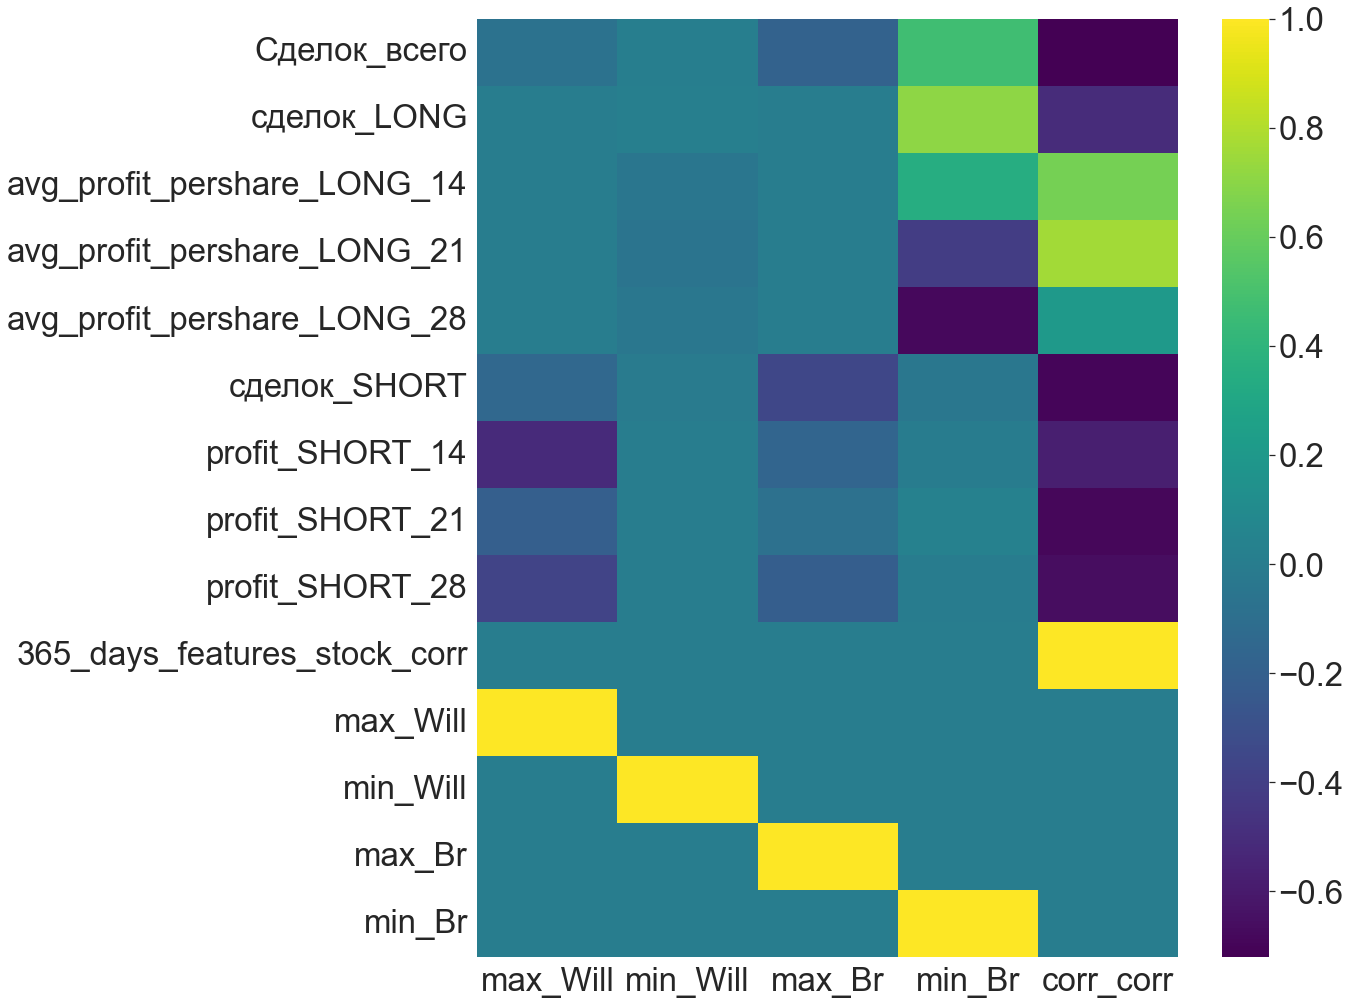

In [428]:
sns.heatmap(gold_corrs, cmap='viridis')
sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
sns.set(rc={'figure.figsize':(15.7,17.27)})
sns.set(font_scale = 3)

## Корреляции по газу

In [396]:
correlations = gas_final.corr()

max_Will_corr = list(correlations["max_Will"])
min_Will_corr = list(correlations["min_Will"])
max_Breeze_corr = list(correlations["max_Br"])
min_Breeze_corr = list(correlations["min_Br"])
corr_corr = list(correlations["365_days_features_stock_corr"])

gas_corrs = pd.DataFrame({'max_Will': max_Will_corr,
                          'min_Will': min_Will_corr,
                          'max_Br': max_Breeze_corr,
                          'min_Br': min_Breeze_corr,
                          'corr_corr': corr_corr}, index = list(correlations["max_Will"].index))
gas_corrs

,max_Will,min_Will,max_Br,min_Br,corr_corr
Сделок_всего,-0.13,0.06,-0.08,0.05,-0.86
сделок_LONG,-0.00,0.10,-0.00,0.09,-0.84
avg_profit_pershare_LONG_14,-0.00,0.27,-0.00,0.01,0.78
avg_profit_pershare_LONG_21,0.00,0.20,0.00,0.04,0.78
avg_profit_pershare_LONG_28,0.00,0.21,-0.00,0.09,0.71
сделок_SHORT,-0.27,0.00,-0.17,0.00,-0.79
profit_SHORT_14,-0.44,0.00,-0.24,-0.00,0.40
profit_SHORT_21,0.26,-0.00,0.09,-0.00,0.22
profit_SHORT_28,0.57,-0.00,0.19,0.00,-0.18
365_days_features_stock_corr,0.00,0.00,0.00,0.00,1.00


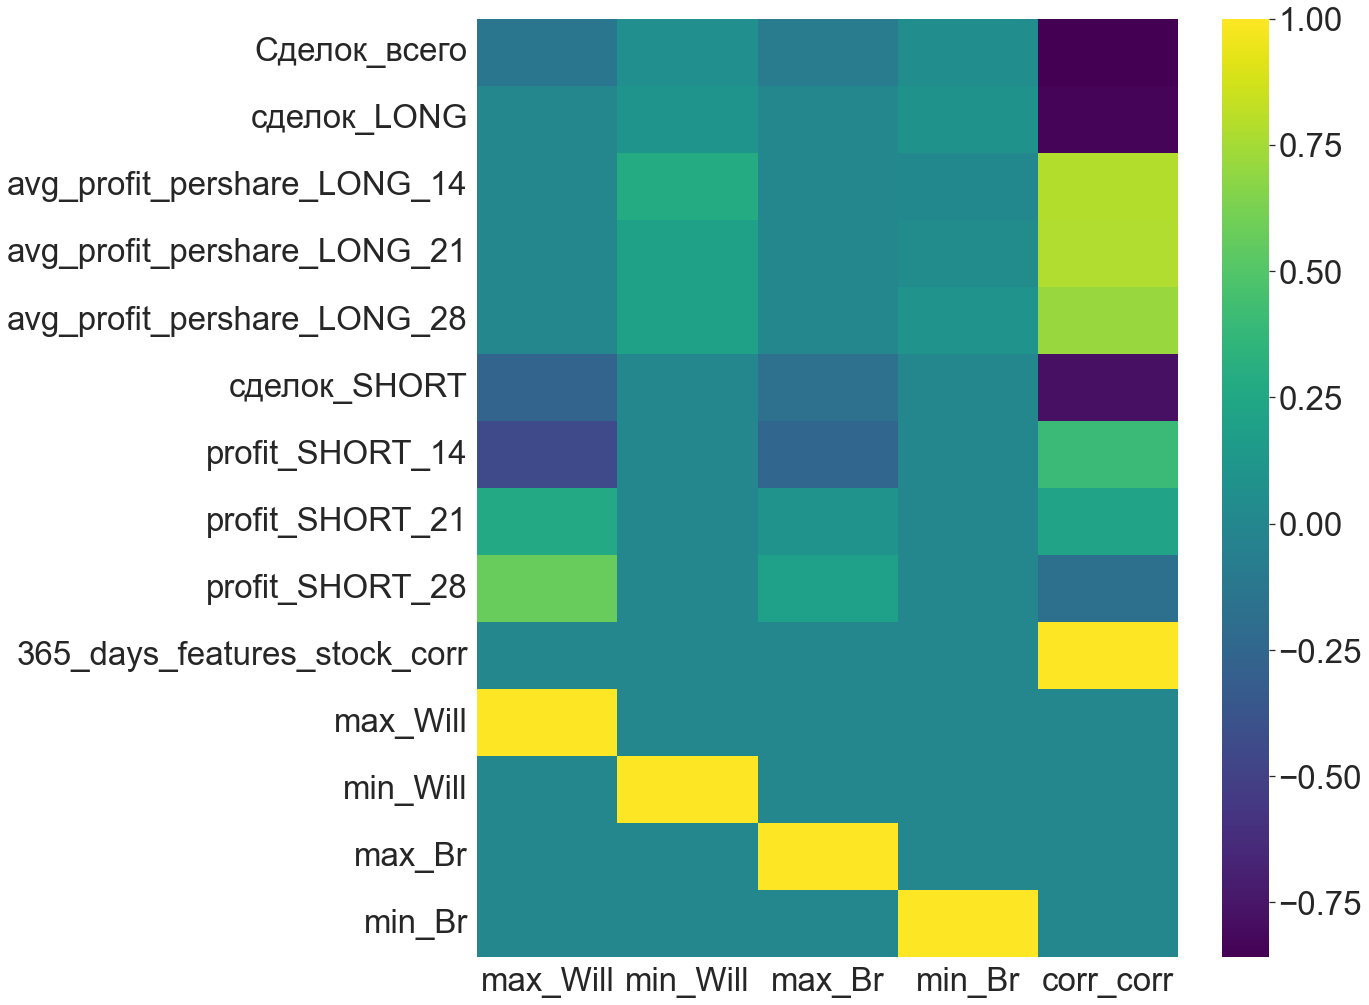

In [427]:
sns.heatmap(gas_corrs, cmap='viridis')
sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
sns.set(rc={'figure.figsize':(15.7,17.27)})
sns.set(font_scale = 3)

## Корреляции по нефти

In [397]:
correlations = oil_final.corr()

max_Will_corr = list(correlations["max_Will"])
min_Will_corr = list(correlations["min_Will"])
max_Breeze_corr = list(correlations["max_Br"])
min_Breeze_corr = list(correlations["min_Br"])
corr_corr = list(correlations["365_days_features_stock_corr"])

oil_corrs = pd.DataFrame({'max_Will': max_Will_corr,
                          'min_Will': min_Will_corr,
                          'max_Br': max_Breeze_corr,
                          'min_Br': min_Breeze_corr,
                          'corr_corr': corr_corr}, index = list(correlations["max_Will"].index))
oil_corrs

,max_Will,min_Will,max_Br,min_Br,corr_corr
Сделок_всего,-0.19,0.23,-0.03,0.15,-0.81
сделок_LONG,0.00,0.33,-0.00,0.21,-0.76
avg_profit_pershare_LONG_14,-0.00,-0.61,-0.00,-0.07,0.08
avg_profit_pershare_LONG_21,-0.00,-0.20,-0.00,-0.06,0.42
avg_profit_pershare_LONG_28,0.00,-0.41,-0.00,0.00,0.35
сделок_SHORT,-0.45,0.01,-0.06,0.01,-0.68
profit_SHORT_14,0.00,0.04,-0.34,-0.02,-0.16
profit_SHORT_21,0.08,0.01,-0.01,-0.10,0.37
profit_SHORT_28,0.32,0.01,0.12,-0.06,0.55
365_days_features_stock_corr,0.00,0.00,0.00,0.00,1.00


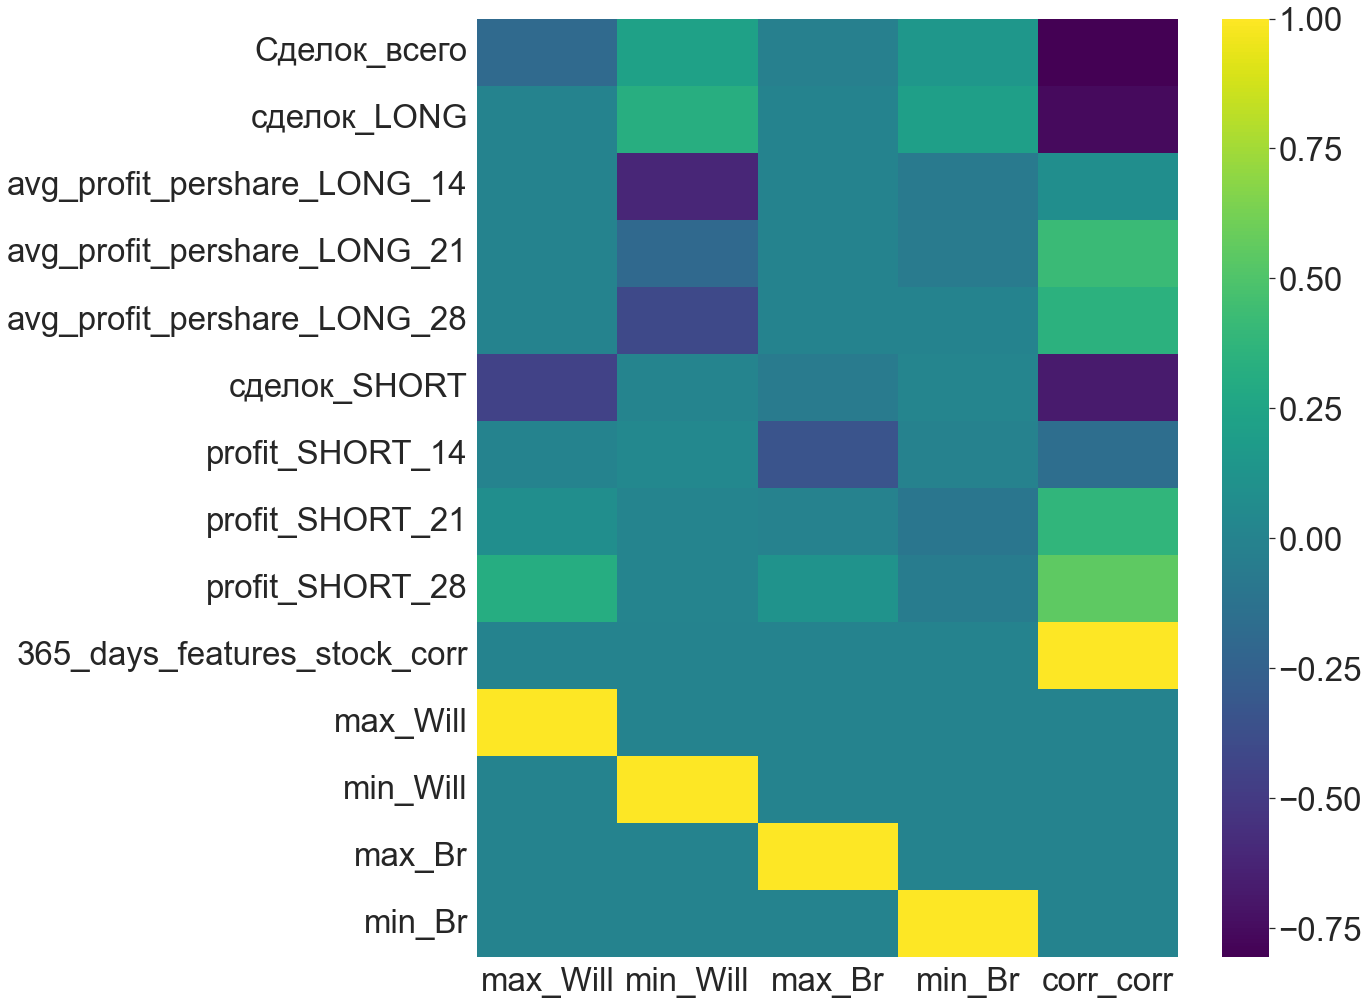

In [426]:
sns.heatmap(oil_corrs, cmap='viridis')
sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
sns.set(rc={'figure.figsize':(15.7,17.27)})
sns.set(font_scale = 3)